### AIR TICKET FARE PREDICTION - MISHA DEY - 1828166

In [1]:
from shutil import copy
copy('../input/air-ticket-fare-prediction/Test.csv','./Test.csv')
copy('../input/air-ticket-fare-prediction/Train.csv','./Train.csv')
copy('../input/air-ticket-fare-prediction/Sample_Submission.csv','./Sample_Submission.csv')

'./Sample_Submission.csv'

In [2]:
import gc
import math
import PIL 
import pandas as pd
import numpy as np
import seaborn 
import datetime
import random
import warnings
import holidays
import datetime
import xgboost as xgb
from scipy import stats
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split , GridSearchCV,cross_val_score,cross_val_predict,cross_validate,RandomizedSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score,max_error,r2_score,median_absolute_error,mean_squared_log_error
from sklearn.feature_selection import VarianceThreshold,SelectKBest,f_regression
from sklearn.preprocessing import MinMaxScaler,normalize,StandardScaler,RobustScaler
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.decomposition import PCA
import featuretools as ft
from sklearn.svm import SVR
from mlxtend.feature_selection import SequentialFeatureSelector,ExhaustiveFeatureSelector

### EXPLORATORY DATA ANALYSIS

In [3]:
test_data = pd.read_csv('Test.csv')
train_data = pd.read_csv('Train.csv')
sample_data = pd.read_csv('Sample_Submission.csv')

In [4]:
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,09-04-2019,Banglore,Delhi,04:00,06:50,2h 50m,non-stop,No info,3943.0
1,IndiGo,03-06-2019,Banglore,Delhi,08:30,11:20,2h 50m,non-stop,No info,4823.0
2,Jet Airways,09-06-2019,Mumbai,Hyderabad,19:35,21:05,1h 30m,non-stop,In-flight meal not included,3210.0
3,Multiple carriers,27-05-2019,Delhi,Cochin,12:50,21:00,8h 10m,1 stop,No info,7005.0
4,Air India,06-06-2019,Delhi,Cochin,06:50,07-06-2021 07:40,24h 50m,2 stops,No info,13381.0


In [5]:
test_data.head()

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,SpiceJet,12-05-2019,Kolkata,Banglore,15:05,20:20,5h 15m,1 stop,No info
1,Air India,15-03-2019,Delhi,Cochin,18:05,21:10,3h 5m,non-stop,No info
2,Jet Airways,24-06-2019,Delhi,Cochin,11:45,25-06-2021 04:25,16h 40m,2 stops,No info
3,SpiceJet,21-06-2019,Kolkata,Banglore,09:00,11:25,2h 25m,non-stop,No info
4,IndiGo,27-04-2019,Kolkata,Banglore,14:25,16:55,2h 30m,non-stop,No info


In [6]:
sample_data

,Price
0,1000.0
1,2000.0
2,13357.0
3,2000.0
4,2000.0


In [7]:
train_data.describe()

,Price
count,8533.000000
mean,9033.123403
std,4350.362526
min,1759.000000
25%,5276.000000
50%,8372.000000
75%,12373.000000
max,31945.000000


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8533 entries, 0 to 8532
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          8533 non-null   object 
 1   Date_of_Journey  8533 non-null   object 
 2   Source           8533 non-null   object 
 3   Destination      8533 non-null   object 
 4   Dep_Time         8533 non-null   object 
 5   Arrival_Time     8533 non-null   object 
 6   Duration         8533 non-null   object 
 7   Total_Stops      8533 non-null   object 
 8   Additional_Info  8533 non-null   object 
 9   Price            8533 non-null   float64
dtypes: float64(1), object(9)
memory usage: 666.8+ KB


### Removing the Null Values

In [9]:
train_data.isnull().sum()   ## WE have no null values

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

### Removing the duplicate values

In [10]:
test_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

In [11]:
train_data.duplicated().sum()

147

In [12]:
train_data = train_data.drop_duplicates()

In [13]:
train_data.shape

(8386, 10)

In [14]:
train_data_1 = train_data.copy()
test_data_1 = test_data.copy()

### FILTERING OUT THE CONSTANT FEATURES

In [15]:
const_feature = []
uniq_val_count = []
unique_cols = dict()
for col in list(train_data.columns):
    uniq_val_count.append(train_data[col].nunique())
    if(train_data[col].nunique()==1):
        const_feature.append(col)
    
print('\n\n\nConstant Features are   :',const_feature)
print('\n\nALL FEATURES WITH UNIQUE VALUES : \n')
pd.DataFrame({'COLUMN NAMES':list(train_data.columns) ,'UNIQUE VALUES COUNT':uniq_val_count})


# Removing the constant feature
train_data=train_data.drop(columns=const_feature)

# Removing the constant feature
test_data=test_data.drop(columns=const_feature)




Constant Features are   : []


ALL FEATURES WITH UNIQUE VALUES : 



In [16]:
# Hence We don't need to remove any Value

### LABEL ENCODING OF CATEGORICAL FEATURES

In [17]:
train_data

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,09-04-2019,Banglore,Delhi,04:00,06:50,2h 50m,non-stop,No info,3943.0
1,IndiGo,03-06-2019,Banglore,Delhi,08:30,11:20,2h 50m,non-stop,No info,4823.0
2,Jet Airways,09-06-2019,Mumbai,Hyderabad,19:35,21:05,1h 30m,non-stop,In-flight meal not included,3210.0
3,Multiple carriers,27-05-2019,Delhi,Cochin,12:50,21:00,8h 10m,1 stop,No info,7005.0
4,Air India,06-06-2019,Delhi,Cochin,06:50,07-06-2021 07:40,24h 50m,2 stops,No info,13381.0
...,...,...,...,...,...,...,...,...,...,...
8528,Air India,09-03-2019,Delhi,Cochin,22:00,10-03-2021 19:15,21h 15m,2 stops,No info,16373.0
8529,Vistara,27-05-2019,Banglore,Delhi,17:00,19:35,2h 35m,non-stop,No info,4878.0
8530,Vistara,24-03-2019,Chennai,Kolkata,07:05,09:20,2h 15m,non-stop,No info,4842.0
8531,Air India,09-03-2019,Delhi,Cochin,04:00,10-03-2021 07:40,27h 40m,1 stop,No info,10315.0


In [18]:
### Assign 0 for unknown classes

class LabelEncoderExt(object):
    def __init__(self):
        self.label_encoder = LabelEncoder()

    def fit(self, data_list):
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_
        return self

    def transform(self, data_list):
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]
        return self.label_encoder.transform(new_data_list)
    
    

In [19]:
details = ['Airline','Source','Destination','Total_Stops','Additional_Info']

label_enc_list = dict()


for col in range(len(details)):
    label_encoder = LabelEncoderExt()
    label_encoder.fit(train_data[details[col]])
    train_data[details[col]] = label_encoder.transform(train_data[details[col]])
    label_enc_list[details[col]]=label_encoder


In [20]:
for col in range(len(details)):
    test_data[details[col]] = label_enc_list[details[col]].transform(test_data[details[col]])

In [21]:
train_data

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,3,09-04-2019,0,2,04:00,06:50,2h 50m,4,7,3943.0
1,3,03-06-2019,0,2,08:30,11:20,2h 50m,4,7,4823.0
2,4,09-06-2019,4,3,19:35,21:05,1h 30m,4,4,3210.0
3,5,27-05-2019,2,1,12:50,21:00,8h 10m,0,7,7005.0
4,1,06-06-2019,2,1,06:50,07-06-2021 07:40,24h 50m,1,7,13381.0
...,...,...,...,...,...,...,...,...,...,...
8528,1,09-03-2019,2,1,22:00,10-03-2021 19:15,21h 15m,1,7,16373.0
8529,9,27-05-2019,0,2,17:00,19:35,2h 35m,4,7,4878.0
8530,9,24-03-2019,1,4,07:05,09:20,2h 15m,4,7,4842.0
8531,1,09-03-2019,2,1,04:00,10-03-2021 07:40,27h 40m,0,7,10315.0


In [22]:
test_data

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,7,12-05-2019,3,0,15:05,20:20,5h 15m,0,7
1,1,15-03-2019,2,1,18:05,21:10,3h 5m,4,7
2,4,24-06-2019,2,1,11:45,25-06-2021 04:25,16h 40m,1,7
3,7,21-06-2019,3,0,09:00,11:25,2h 25m,4,7
4,3,27-04-2019,3,0,14:25,16:55,2h 30m,4,7
...,...,...,...,...,...,...,...,...,...
2129,1,06-04-2019,0,2,17:00,19:45,2h 45m,4,7
2130,4,01-04-2019,3,0,06:30,20:45,14h 15m,0,7
2131,5,15-05-2019,2,1,08:45,19:00,10h 15m,0,7
2132,1,03-03-2019,2,1,21:30,04-03-2021 19:15,21h 45m,1,7


### DATE-TIME CONVERSION

In [23]:
time_cols = ['Dep_Time']
time_dur = ['Duration']
date_cols = ['Date_of_Journey']

for col in date_cols:
    train_data['{}_month'.format(col)] =  pd.to_datetime(train_data['{}'.format(col)],format='%d-%m-%Y').dt.month
    train_data['{}_day'.format(col)] =  pd.to_datetime(train_data['{}'.format(col)],format='%d-%m-%Y').dt.day
    train_data['{}_year'.format(col)] =  pd.to_datetime(train_data['{}'.format(col)],format='%d-%m-%Y').dt.year

for col in time_cols:
    train_data['{}_hour'.format(col)] =  pd.to_datetime(train_data['{}'.format(col)],format='%H:%M').dt.hour
    train_data['{}_minutes'.format(col)] =  pd.to_datetime(train_data['{}'.format(col)],format='%H:%M').dt.minute

    

In [24]:
x=train_data['Duration'].map(lambda x: x.replace('h',':').replace(' ','').replace('m',':'))
def mapper(elems):
    if elems[0] == '':
        return int(elems[1])
        
    elif elems[1] == '':
        return int(int(elems[0])*60)
    else:
        return int(int(elems[0])*60 + int(elems[1]))
        
y = x.map(lambda i : mapper(i.split(':')))


In [25]:
train_data['Duration_minutes'] = y

In [26]:
train_data = train_data.sort_values(by='Date_of_Journey').reset_index(drop=True)
#train_data = train_data.drop(columns=['Date_of_Journey','Dep_Time','Arrival_Time','Duration'])

In [27]:
for col in date_cols:
    test_data['{}_month'.format(col)] =  pd.to_datetime(test_data['{}'.format(col)],format='%d-%m-%Y').dt.month
    test_data['{}_day'.format(col)] =  pd.to_datetime(test_data['{}'.format(col)],format='%d-%m-%Y').dt.day
    test_data['{}_year'.format(col)] =  pd.to_datetime(test_data['{}'.format(col)],format='%d-%m-%Y').dt.year

for col in time_cols:
    test_data['{}_hour'.format(col)] =  pd.to_datetime(test_data['{}'.format(col)],format='%H:%M').dt.hour
    test_data['{}_minutes'.format(col)] =  pd.to_datetime(test_data['{}'.format(col)],format='%H:%M').dt.minute

x=test_data['Duration'].map(lambda x: x.replace('h',':').replace(' ','').replace('m',':'))
        
y = x.map(lambda i : mapper(i.split(':')))

test_data['Duration_minutes'] = y

test_data = test_data.drop(columns=['Dep_Time','Arrival_Time','Duration'])

In [28]:
#train_data = train_data.drop(columns = ['Date_of_Journey_year'] )
#test_data = test_data.drop(columns = ['Date_of_Journey_year'] )


### FILTERING OUT THE QUASI-CONSTANT FEATURE

selection = VarianceThreshold(threshold=0.01) # of more that 99% values are same -- we remove the column

cols = list(set(train_data.columns) - set(['Dep_Time','Date_of_Journey_year','Arrival_Time','Duration']))

selection.fit(train_data[cols])

print("No. of Features that are Quasi-Constant : ",(len(cols) - sum(selection.get_support())))

quasi_ = list(selection.get_support())

for i in range(len(quasi_)):
    if quasi_[i] == False:
        print("The Quasi-Constant Feature in train data is  :",cols[i])
        train_data=train_data.drop(columns=[cols[i]])
for i in range(len(quasi_)):
    if quasi_[i] == False:
        print("The Quasi-Constant Feature in test data is  :",cols[i])
        test_dataset=test_dataset.drop(columns=[cols[i]])


### DATA VISUALIZATION

In [29]:
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Journey_month,Date_of_Journey_day,Date_of_Journey_year,Dep_Time_hour,Dep_Time_minutes,Duration_minutes
0,3,01-03-2019,4,3,02:30,04:00,1h 30m,4,7,16000.0,3,1,2019,2,30,90
1,4,01-03-2019,0,5,11:40,02-03-2021 07:40,20h,0,7,22270.0,3,1,2019,11,40,1200
2,3,01-03-2019,0,5,05:15,10:00,4h 45m,0,5,8064.0,3,1,2019,5,15,285
3,3,01-03-2019,0,5,16:55,19:45,2h 50m,4,7,12649.0,3,1,2019,16,55,170
4,3,01-03-2019,1,4,05:15,07:35,2h 20m,4,7,7295.0,3,1,2019,5,15,140


In [30]:
test_data.head()

,Airline,Date_of_Journey,Source,Destination,Total_Stops,Additional_Info,Date_of_Journey_month,Date_of_Journey_day,Date_of_Journey_year,Dep_Time_hour,Dep_Time_minutes,Duration_minutes
0,7,12-05-2019,3,0,0,7,5,12,2019,15,5,315
1,1,15-03-2019,2,1,4,7,3,15,2019,18,5,185
2,4,24-06-2019,2,1,1,7,6,24,2019,11,45,1000
3,7,21-06-2019,3,0,4,7,6,21,2019,9,0,145
4,3,27-04-2019,3,0,4,7,4,27,2019,14,25,150


### CORRELATION MATRIX

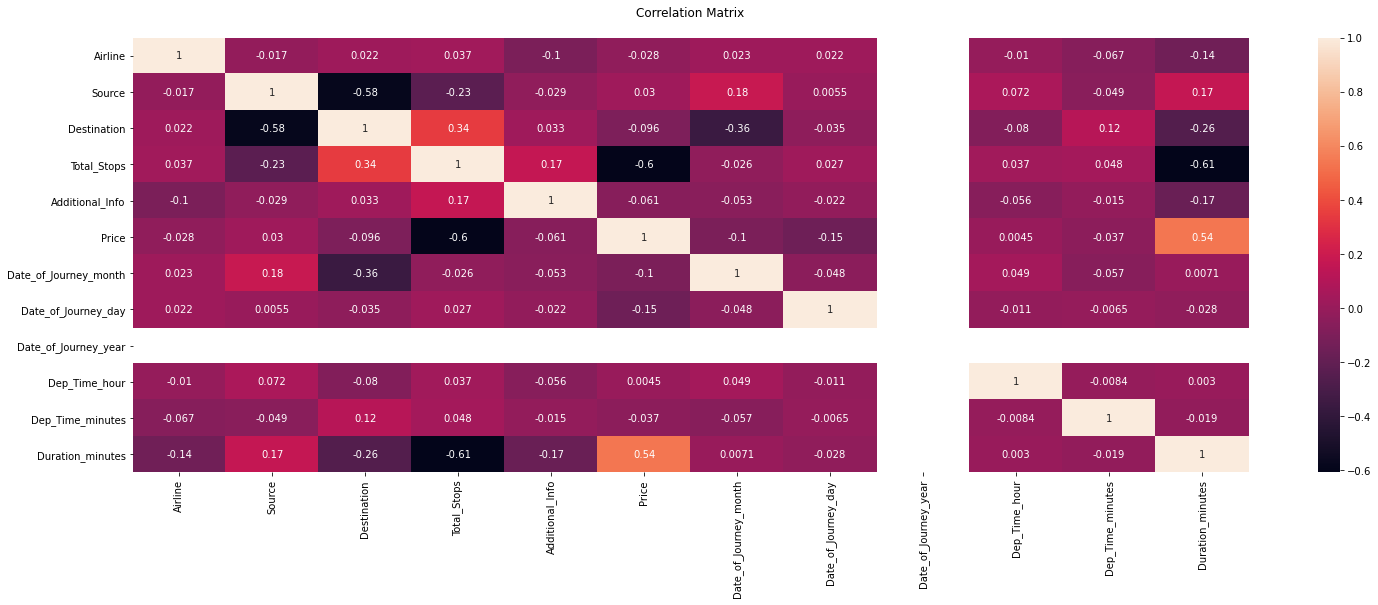

In [31]:
plt.figure(figsize=(25,8))
plt.title('Correlation Matrix\n')
seaborn.heatmap(train_data.corr(),annot=True)
plt.show()

### COVARIANCE MATRIX

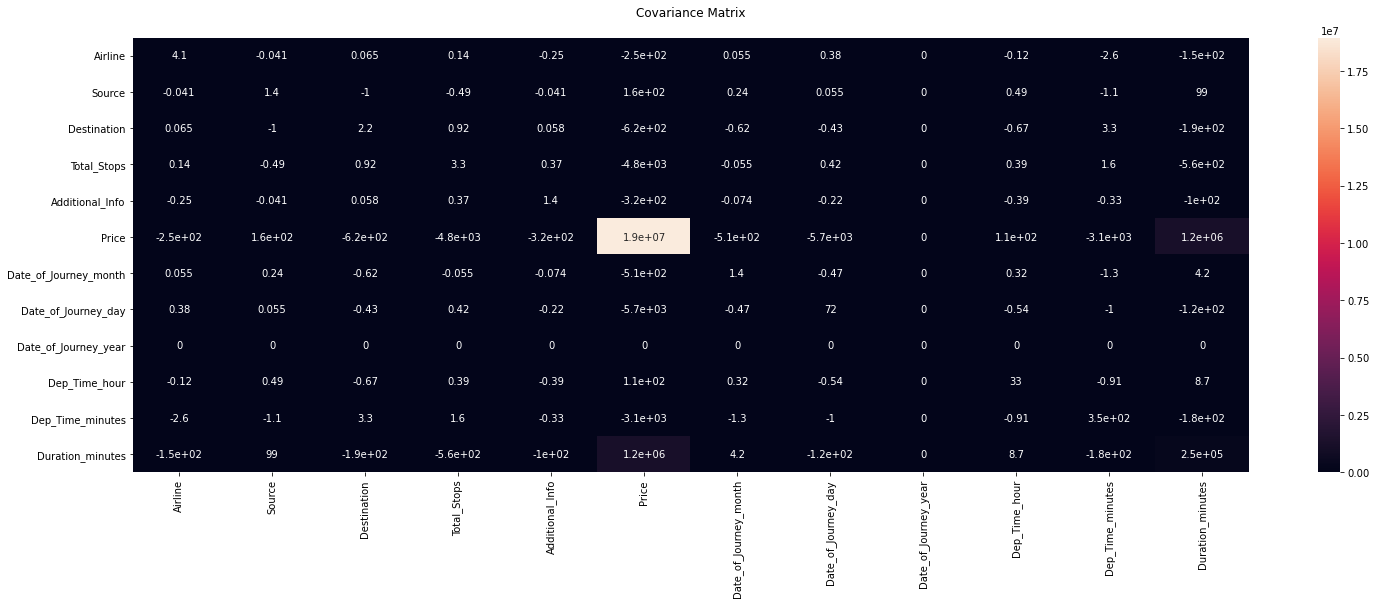

In [32]:
plt.figure(figsize=(25,8))
plt.title('Covariance Matrix\n')
seaborn.heatmap(train_data.cov(),annot=True)
plt.show()

### PIE PLOT

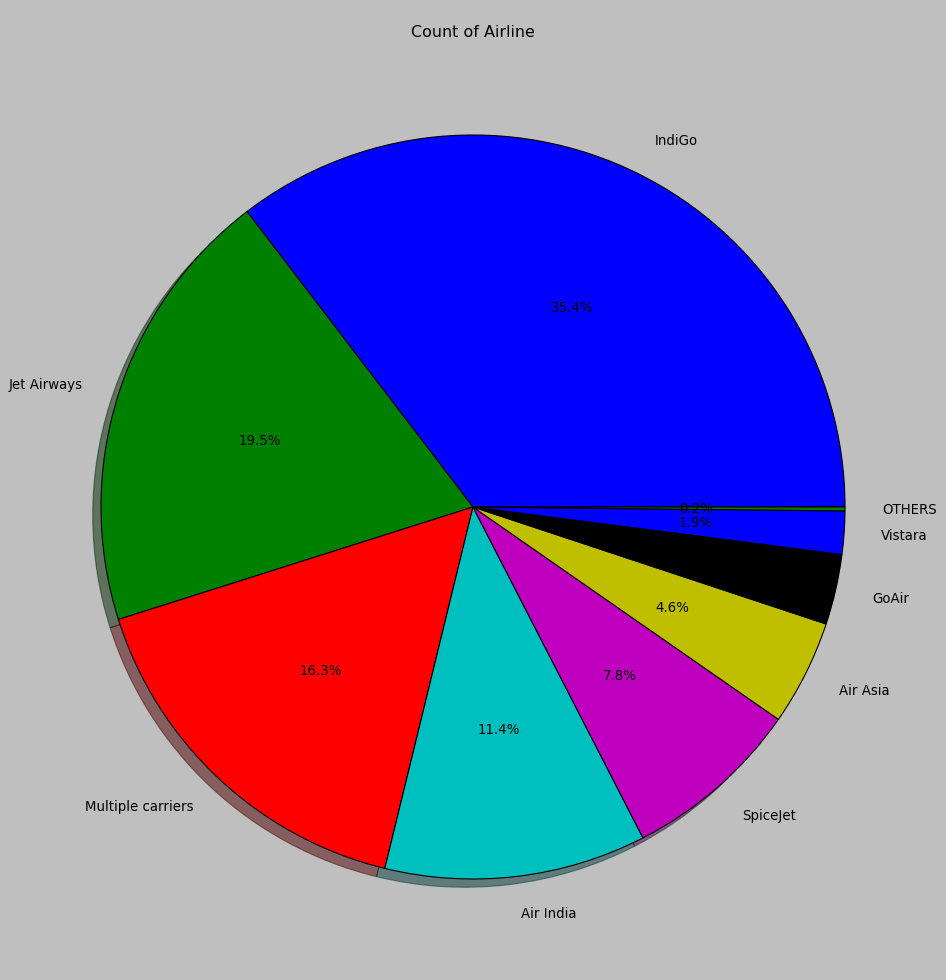

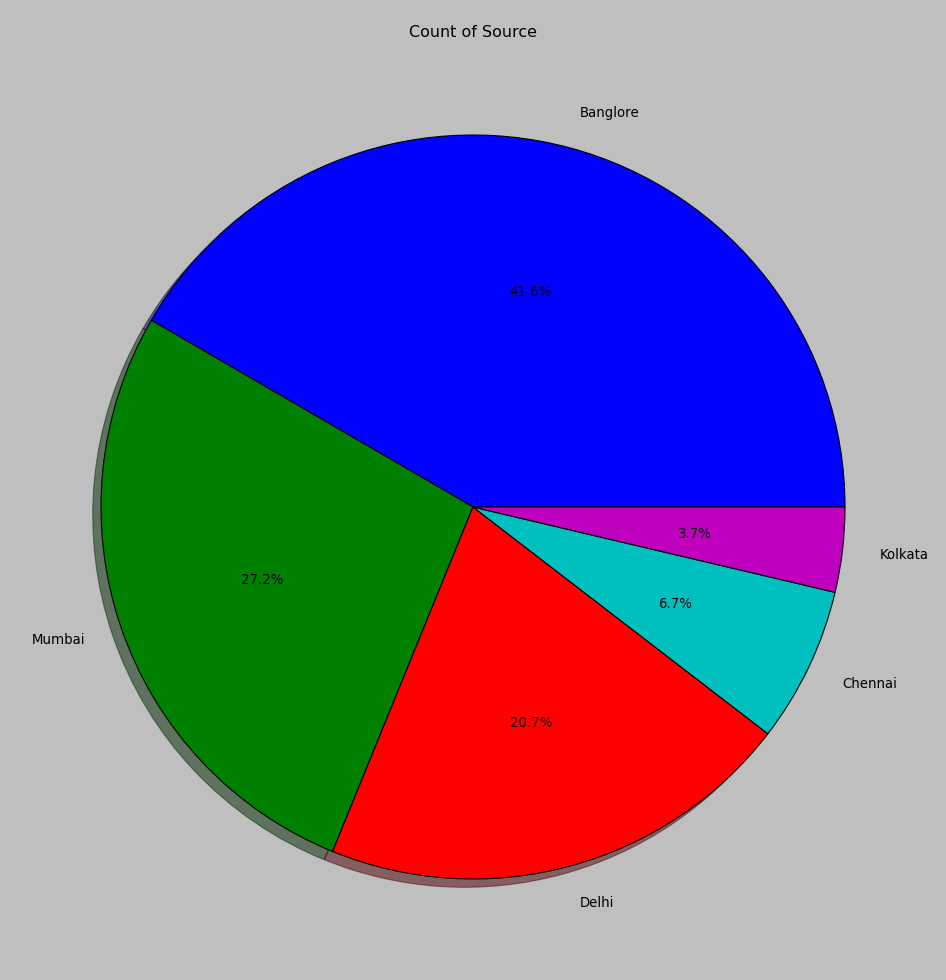

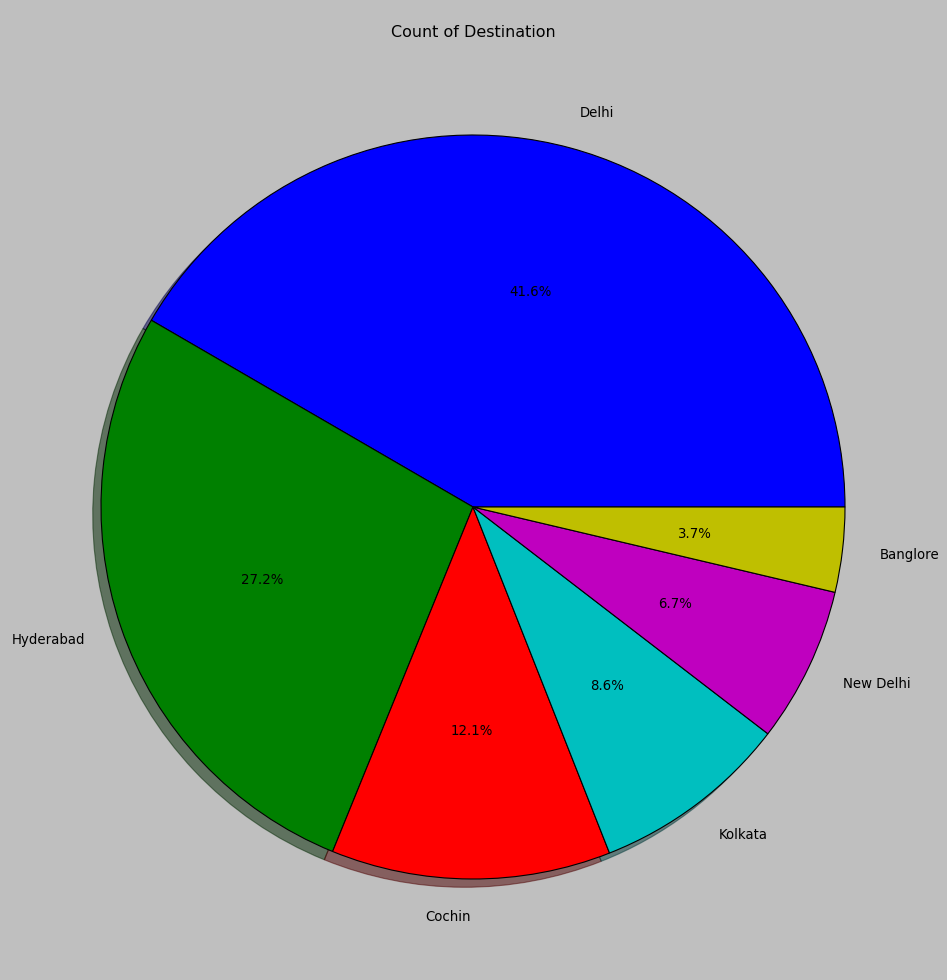

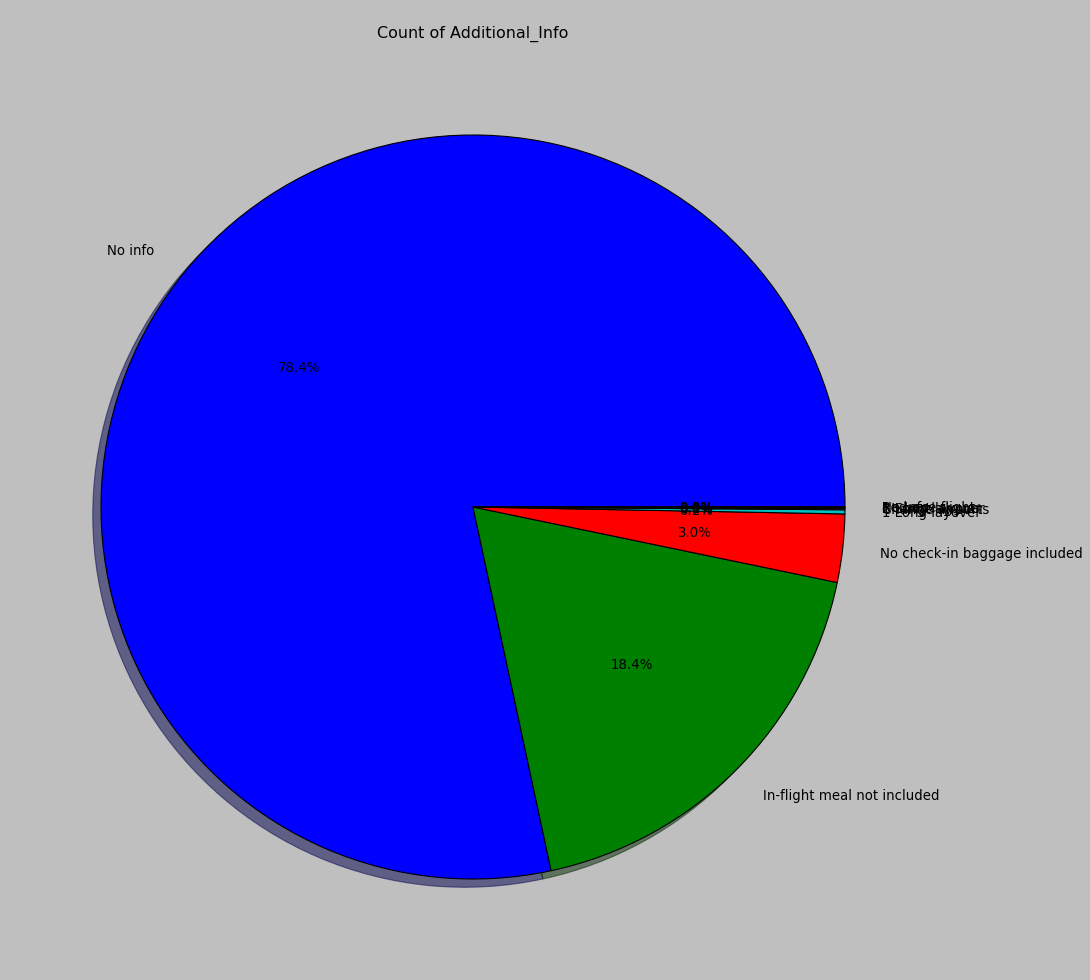

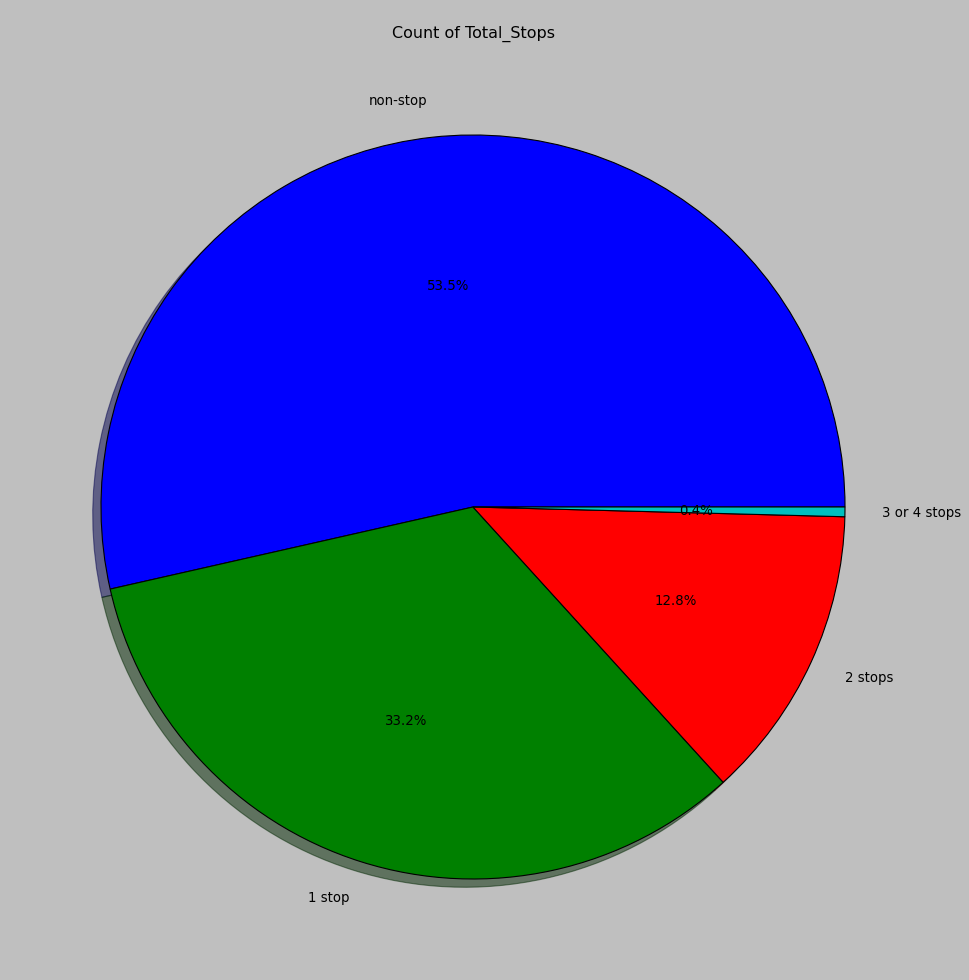

In [33]:
for col in ['Airline','Source', 'Destination','Additional_Info','Total_Stops']:
    plt.style.use('classic')
    plt.figure(figsize=(15,15))
    plt.pie(train_data_1[col].value_counts(),labels=train_data_1[col].unique(),shadow=True,autopct='%0.1f%%')
    plt.title('\nCount of {}'.format(col))
    plt.show()

### BAR PLOT 

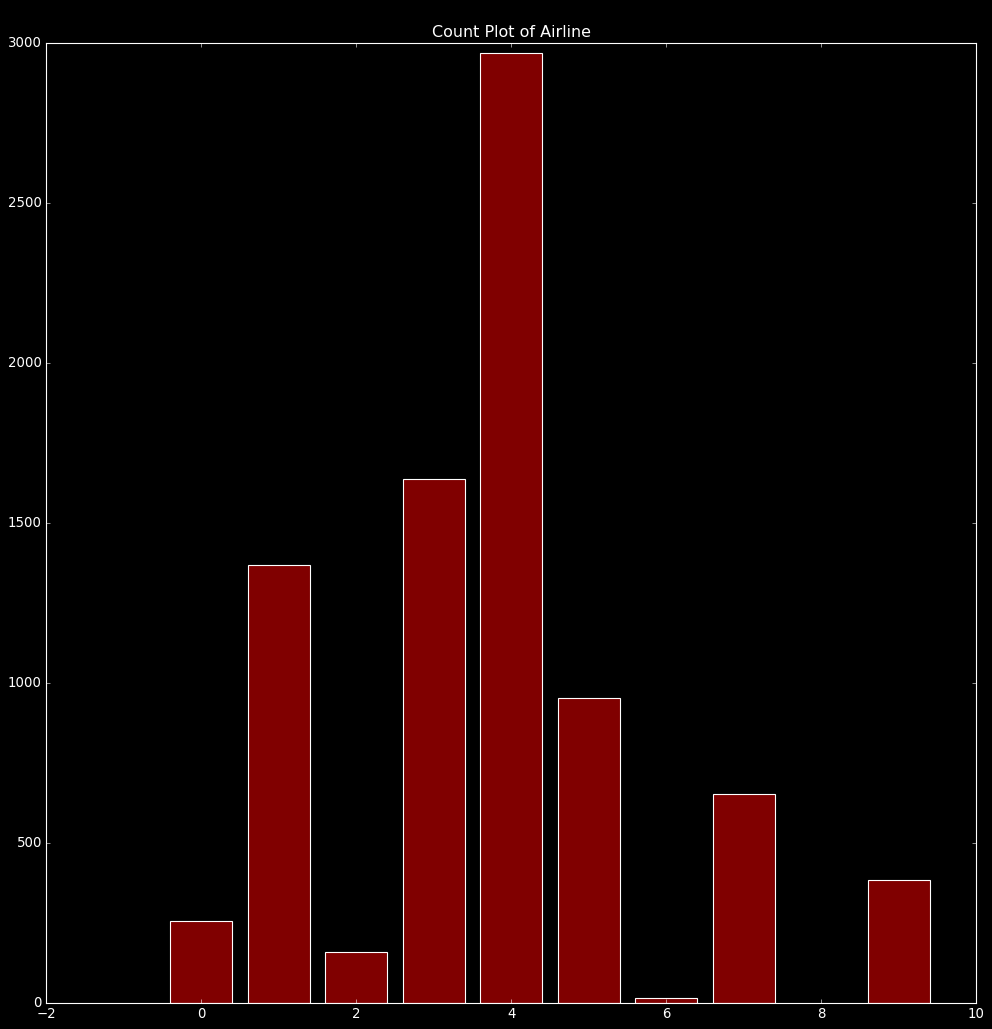

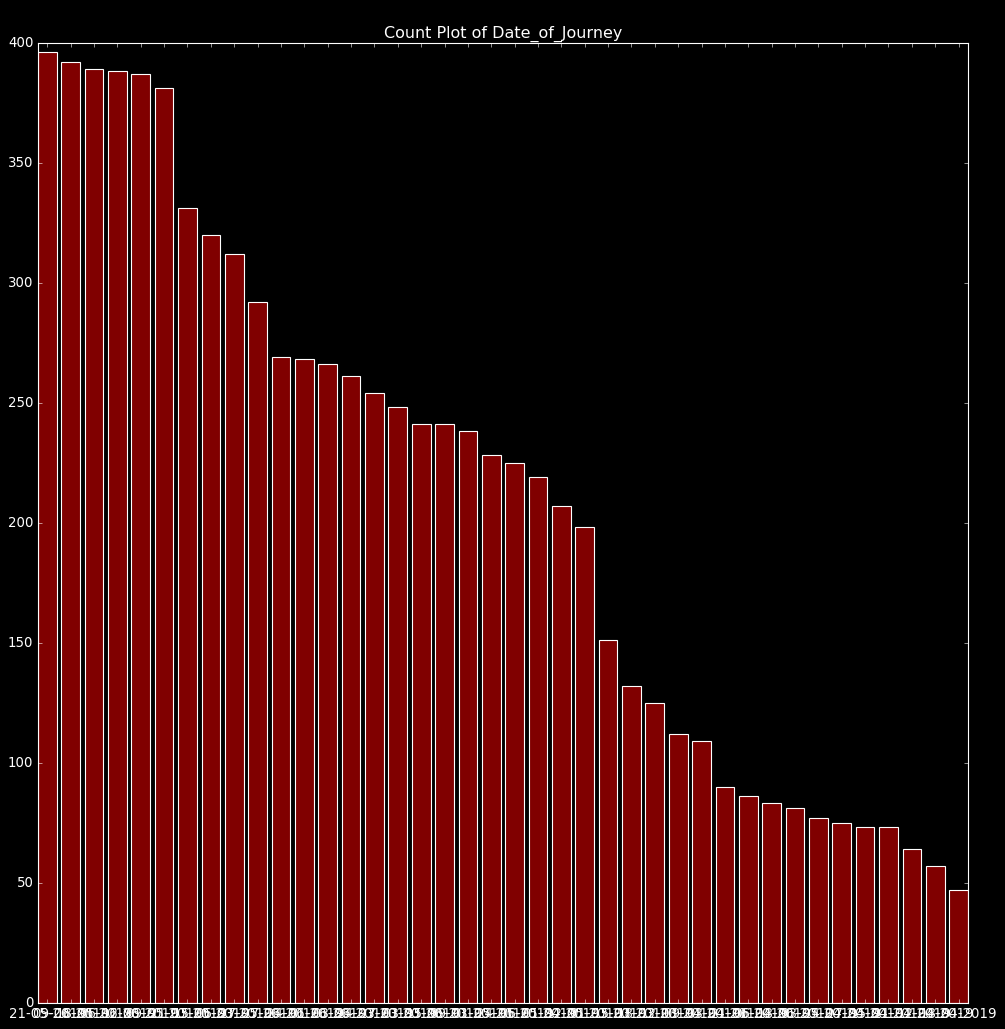

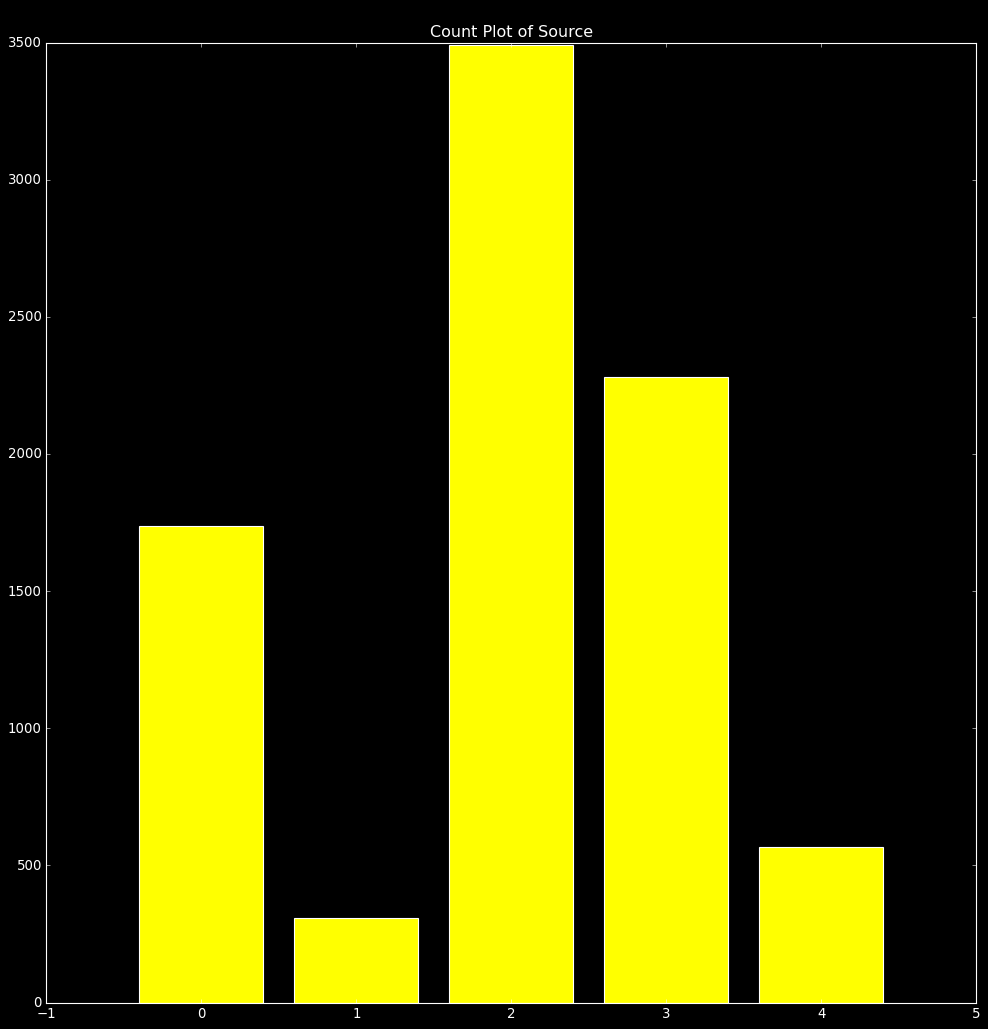

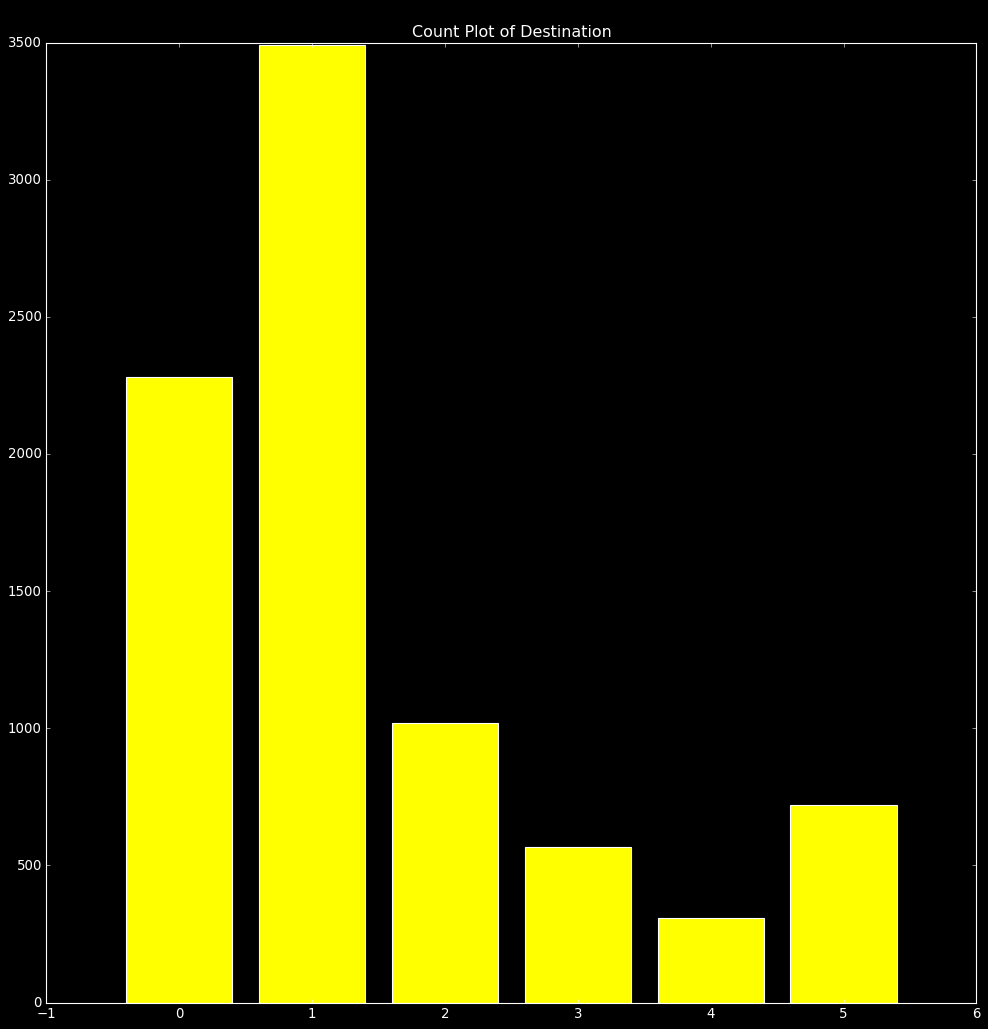

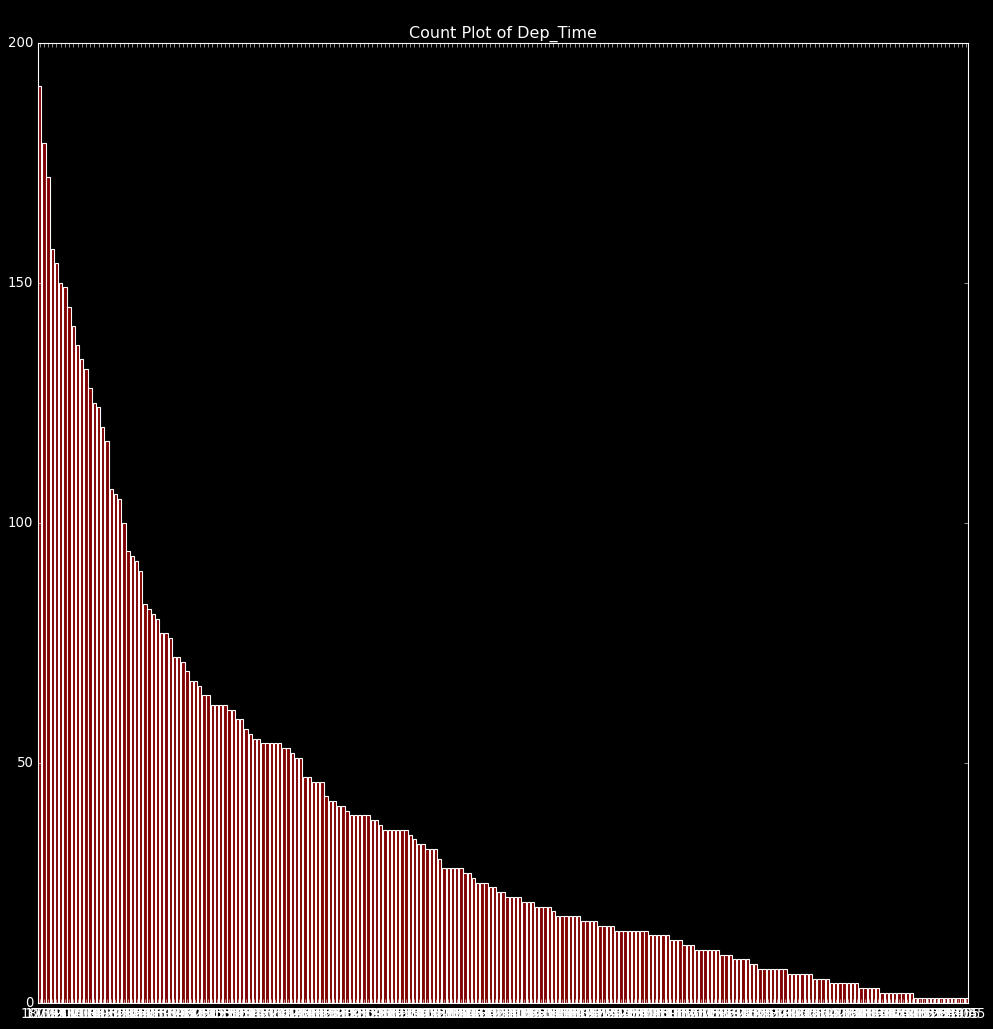

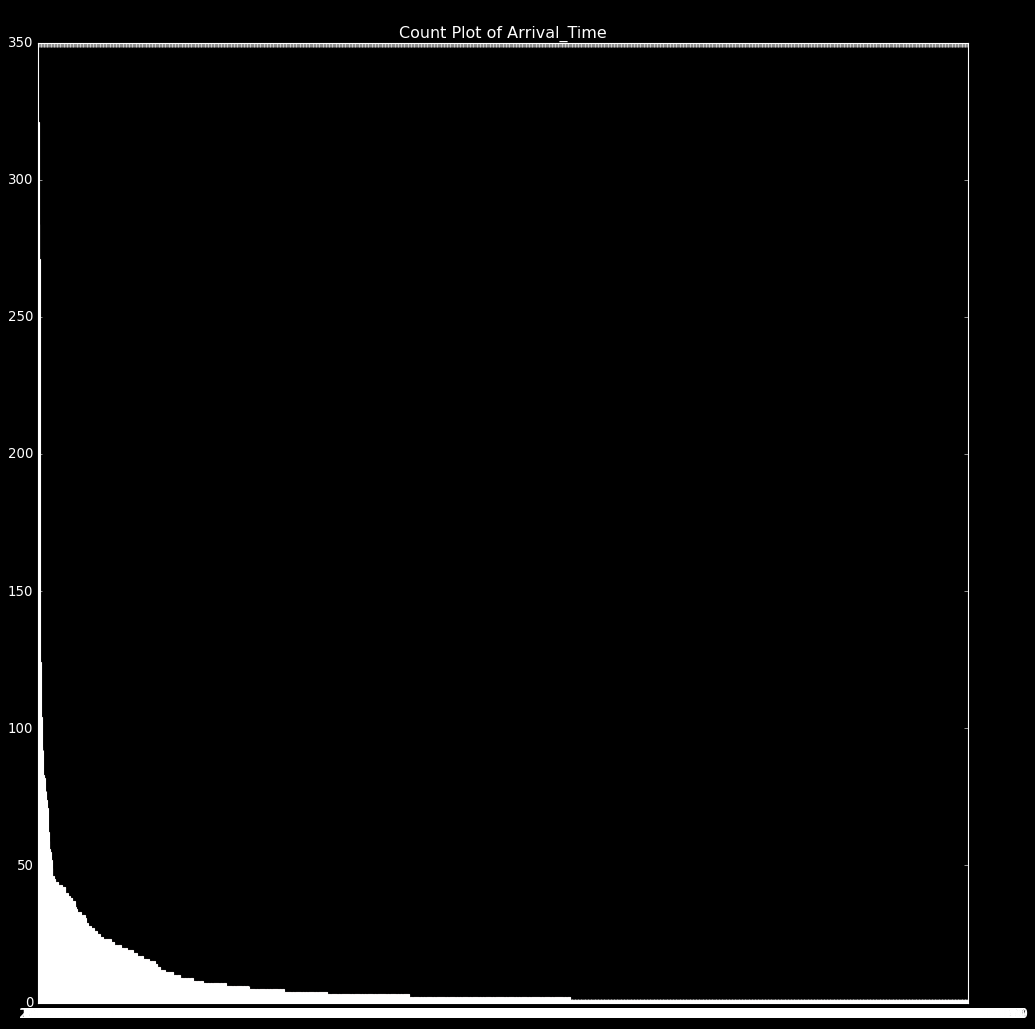

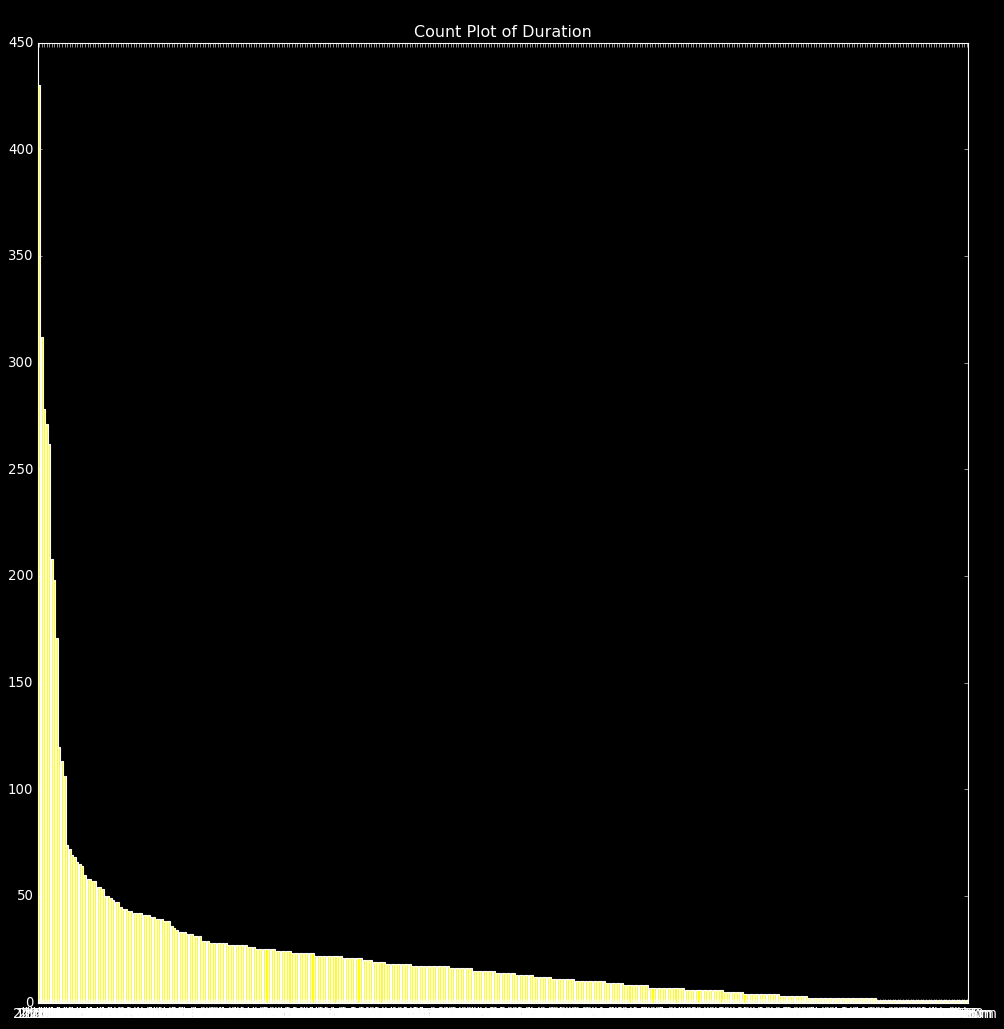

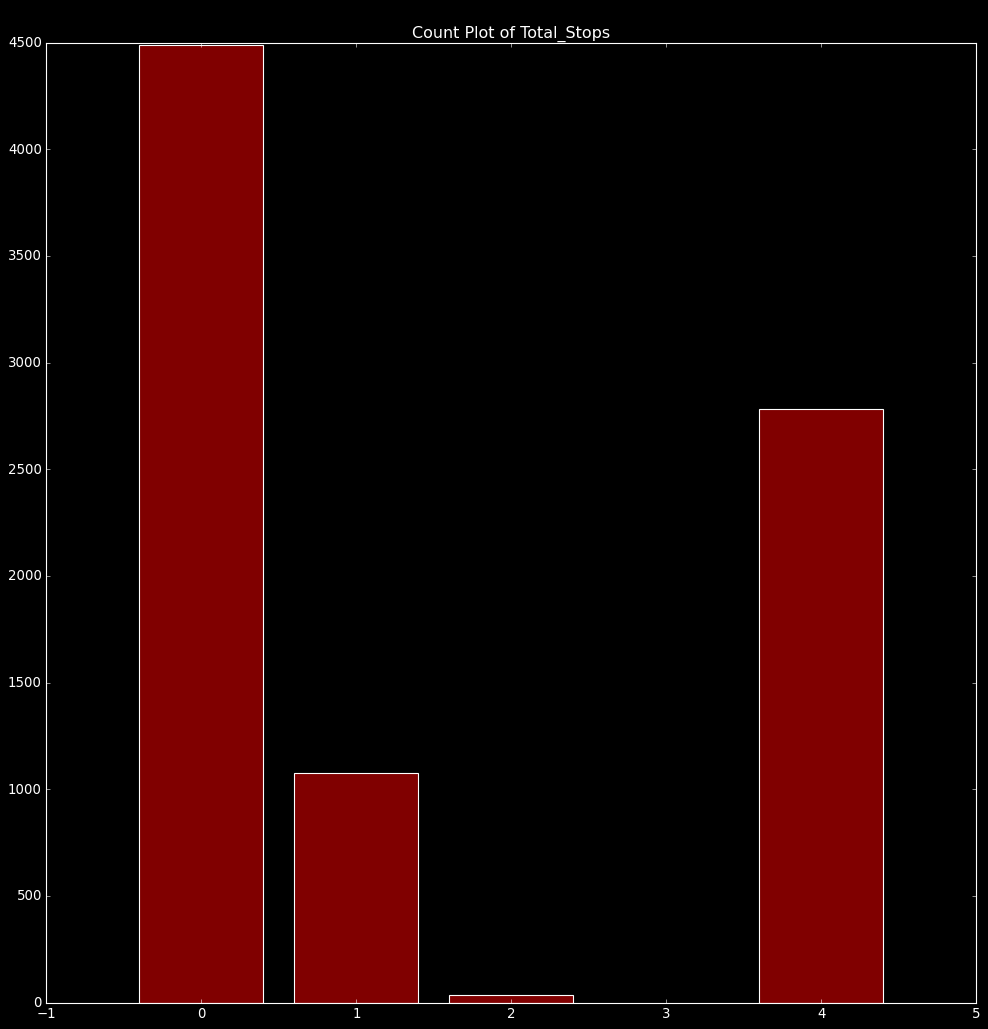

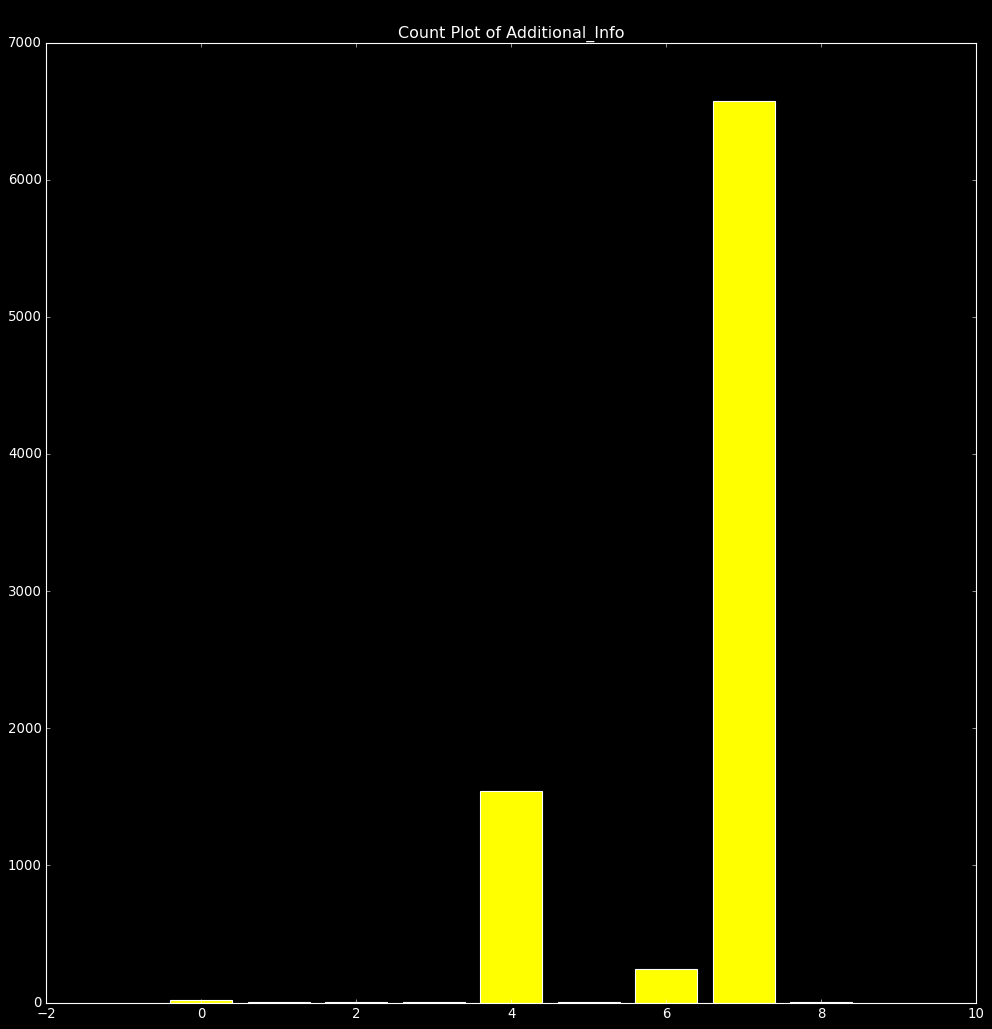

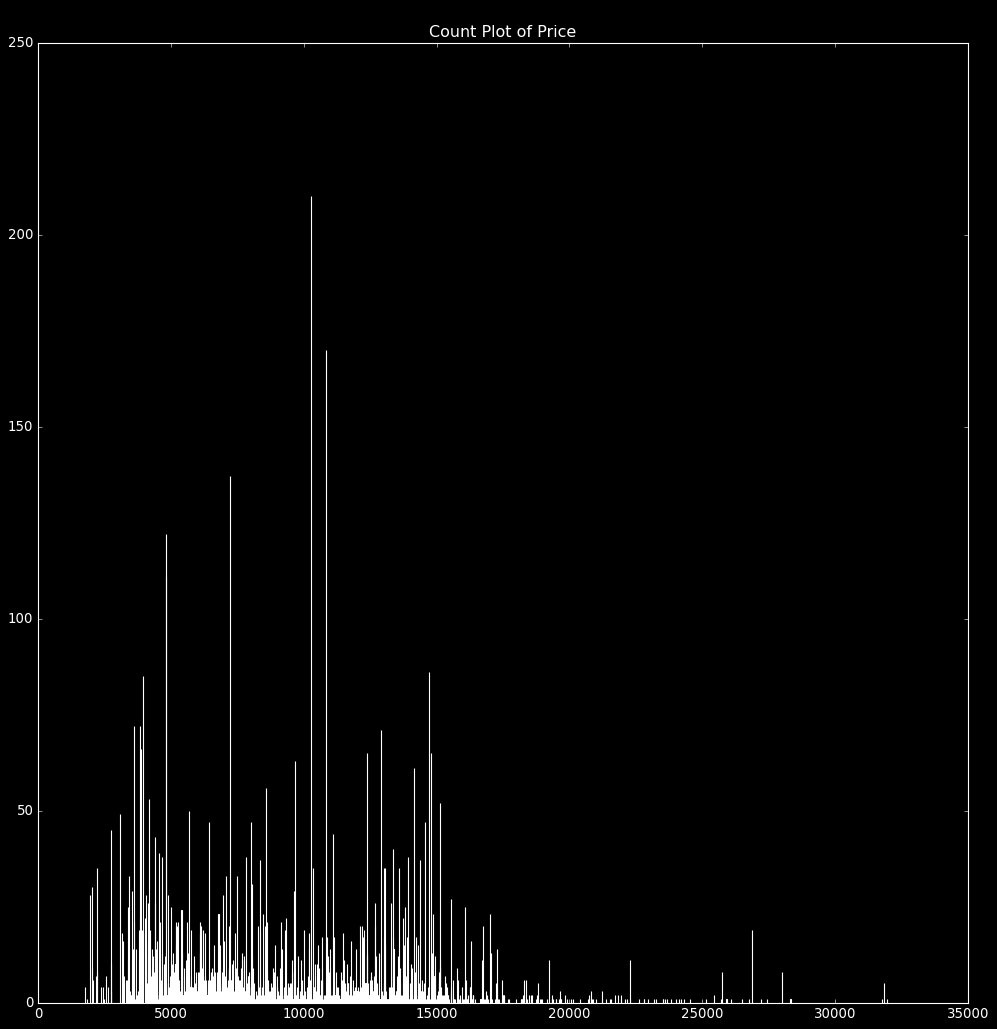

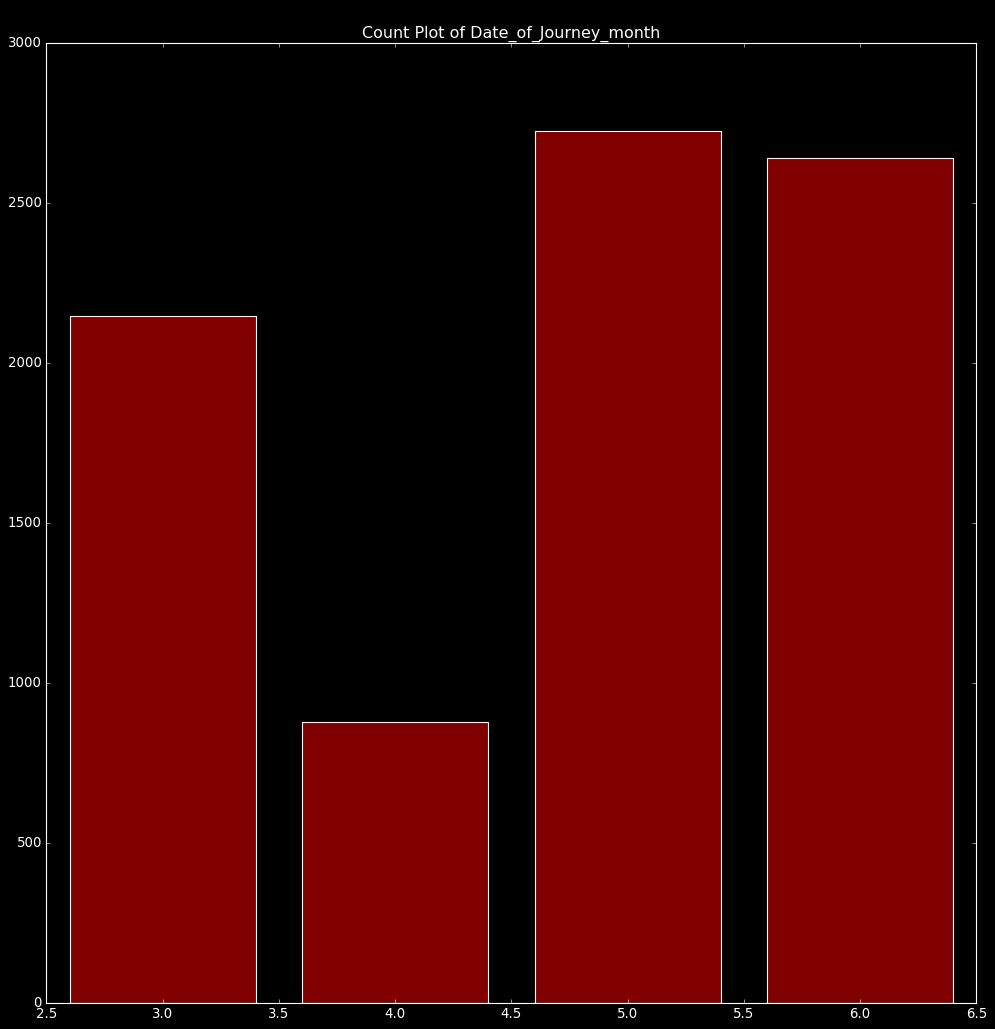

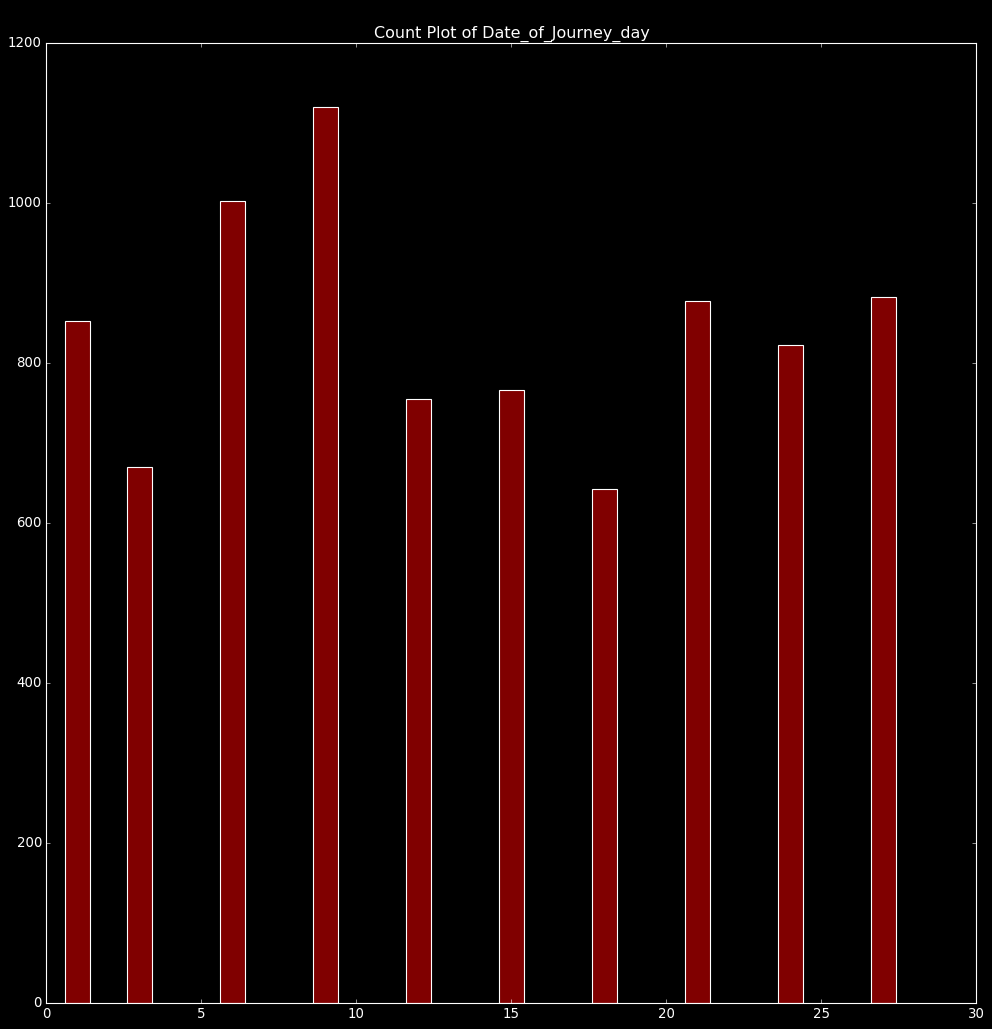

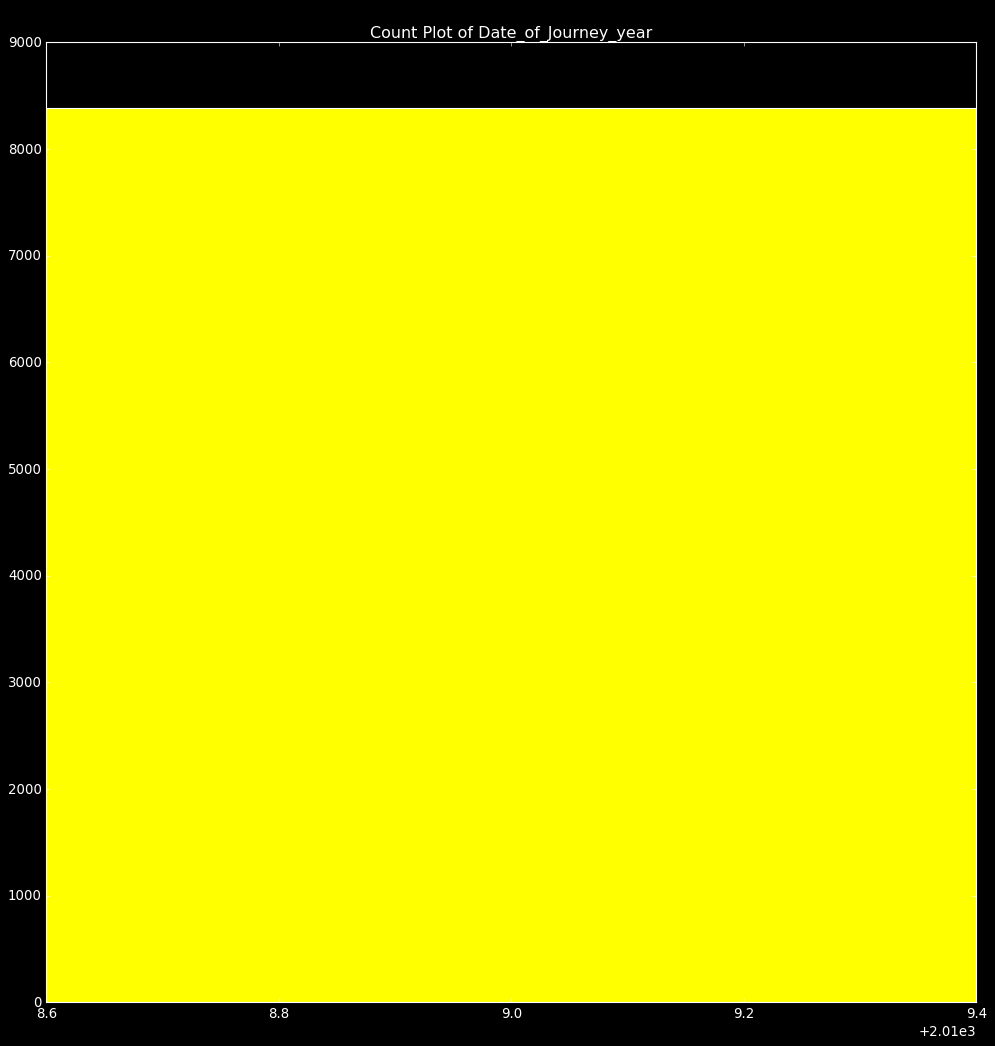

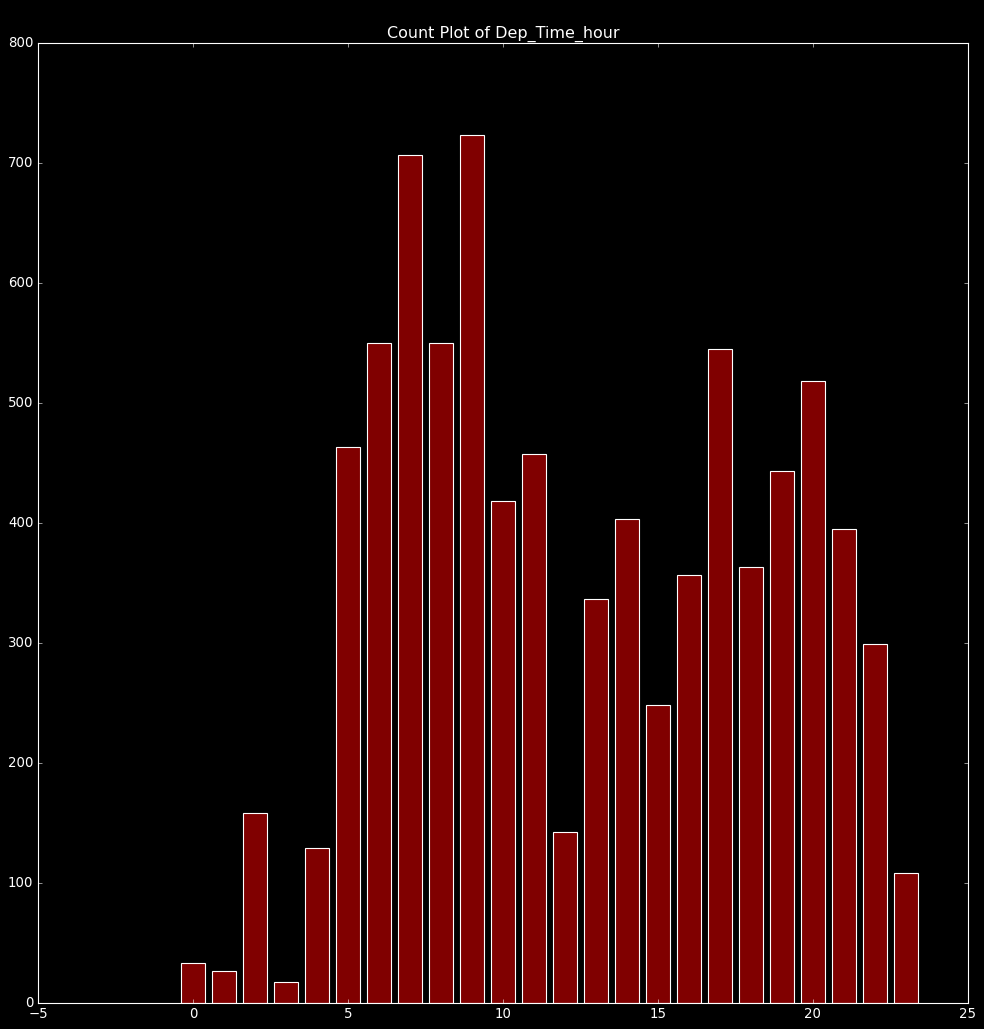

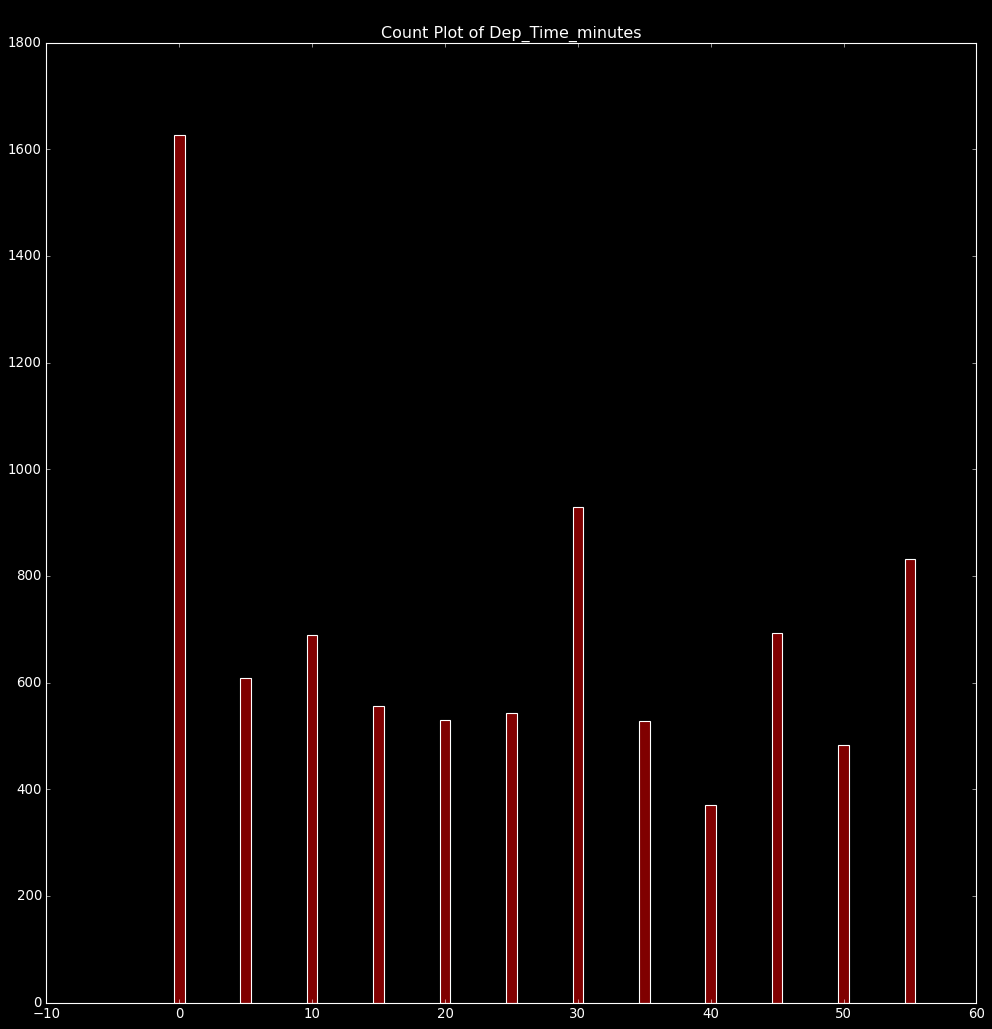

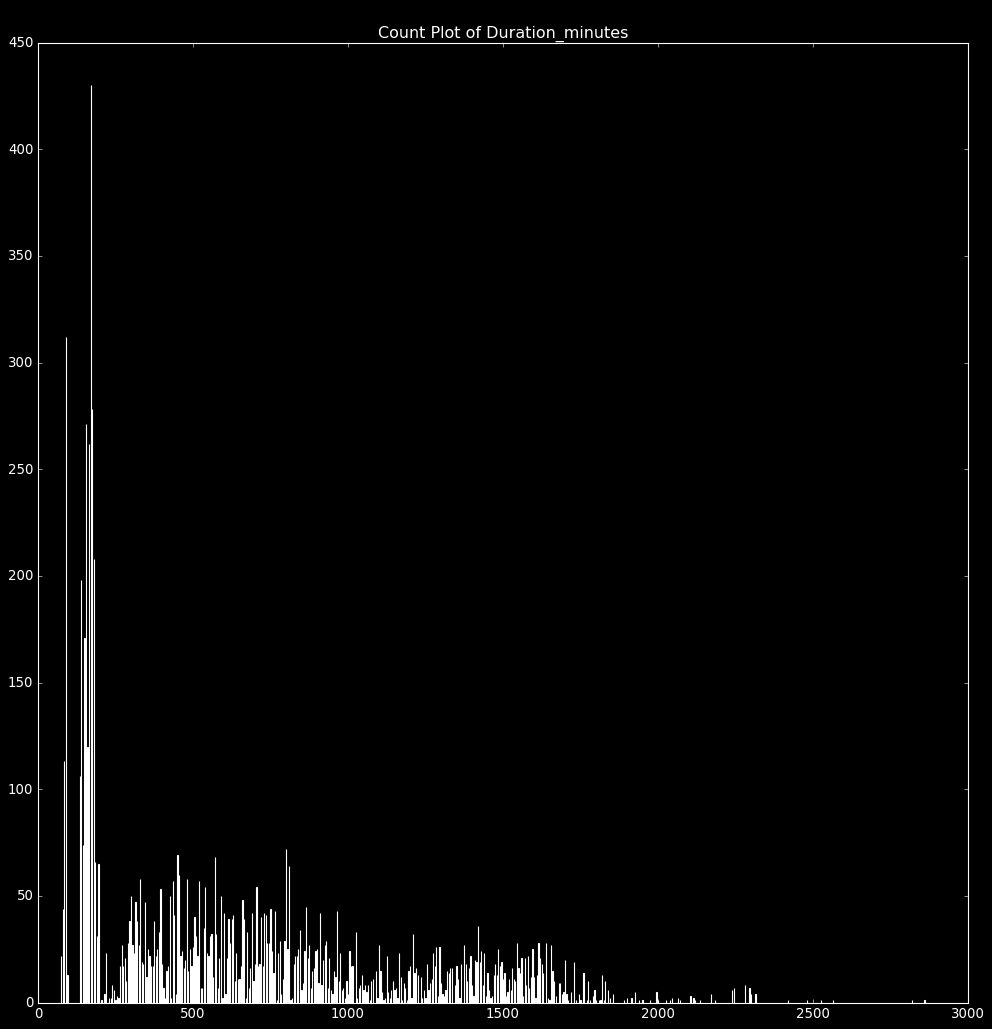

In [34]:
features = train_data.columns

for col in features:
    plt.style.use('dark_background')
    plt.figure(figsize=(15,15))
    plt.bar(list(train_data[col].value_counts().index),list(train_data[col].value_counts()),color = random.sample(['maroon','yellow'],1))            
    plt.title('\nCount Plot of {}'.format(col))
    plt.show()

### SCATTER PLOTS 

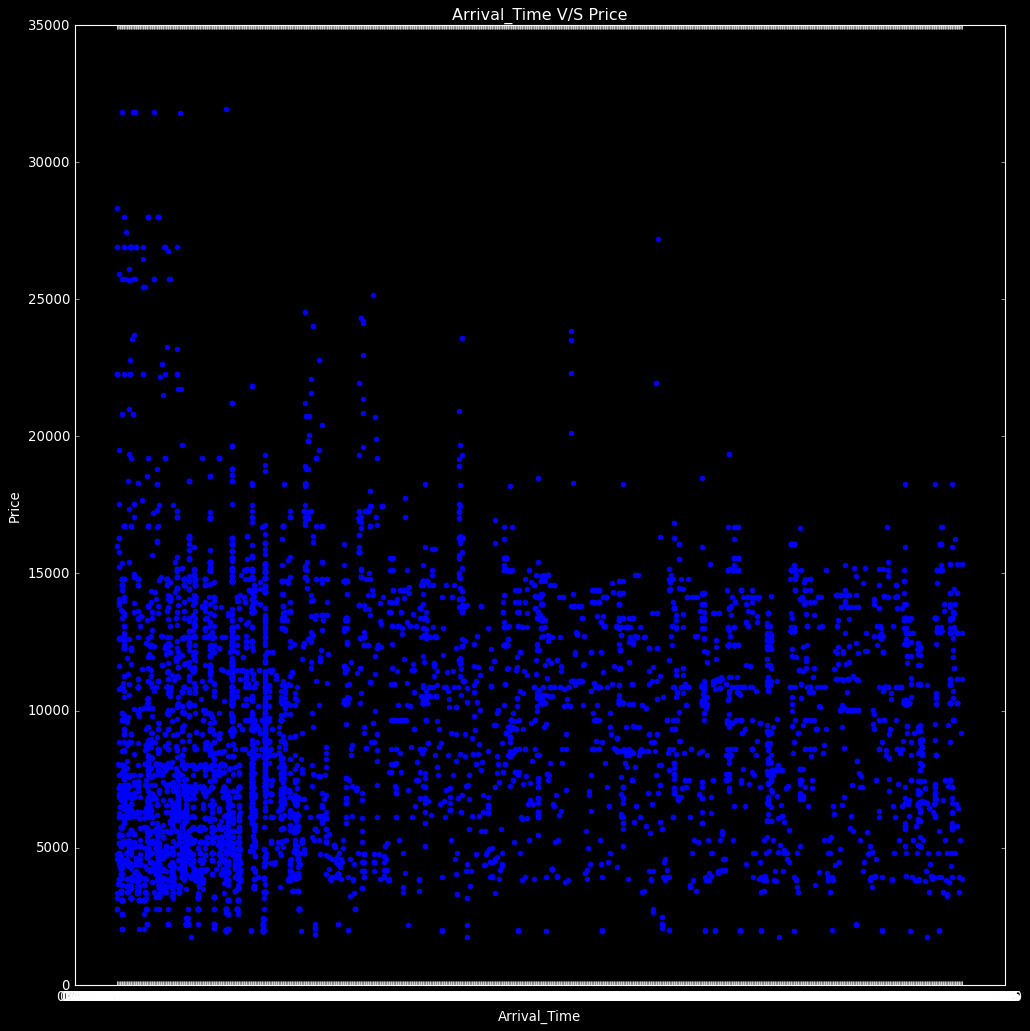

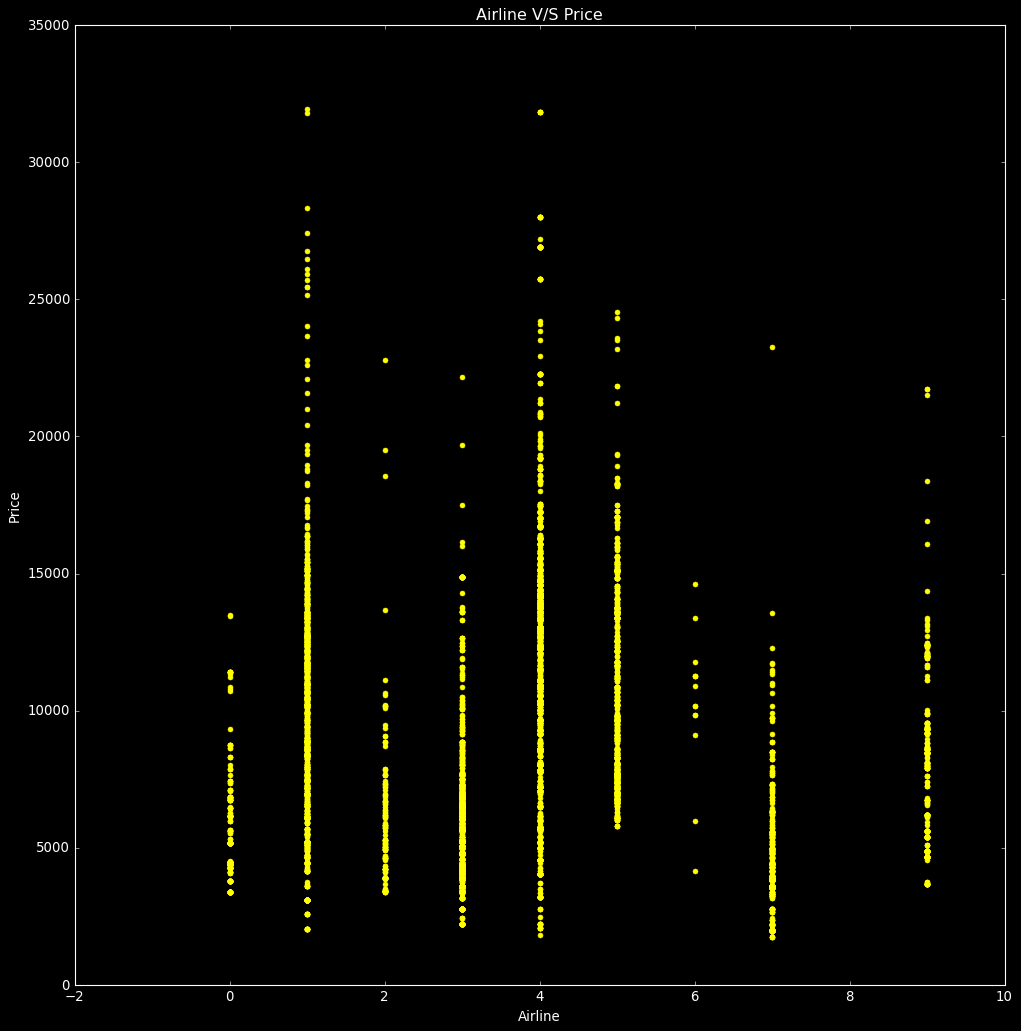

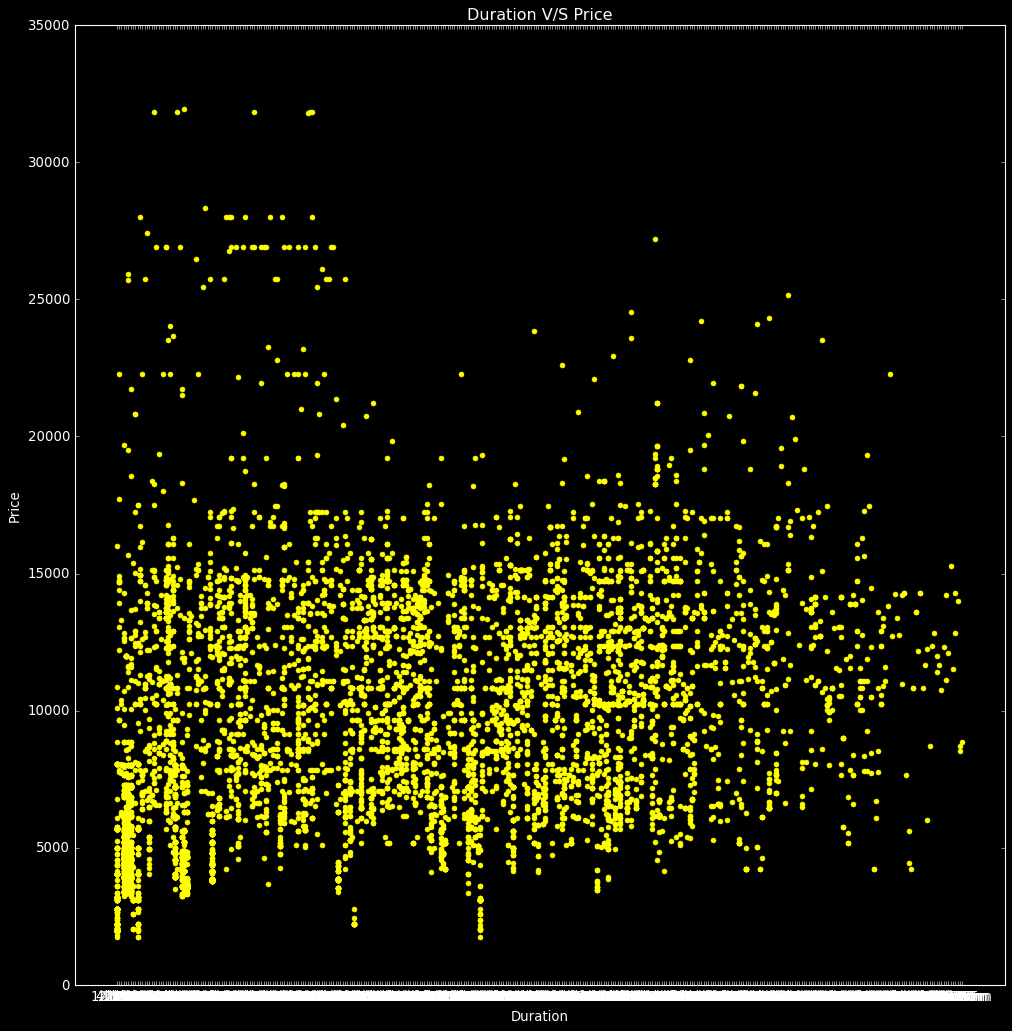

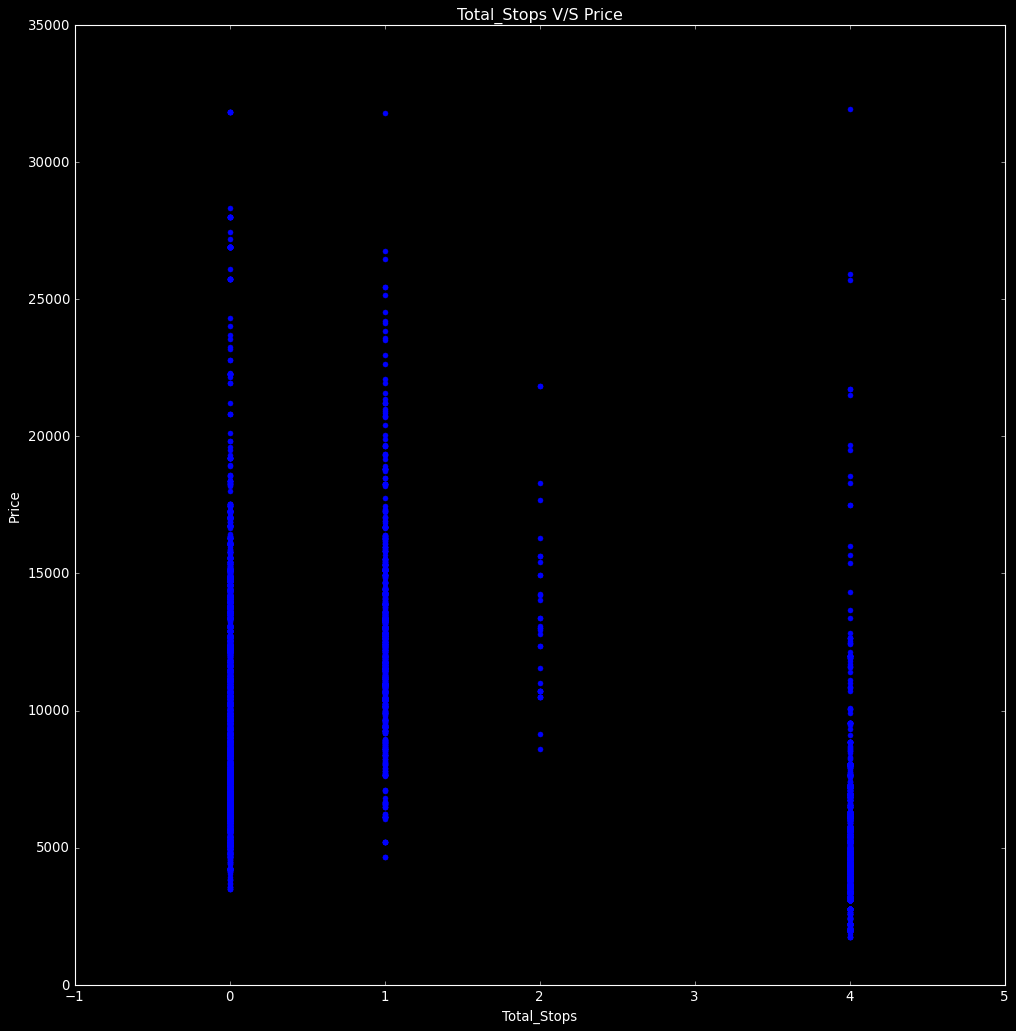

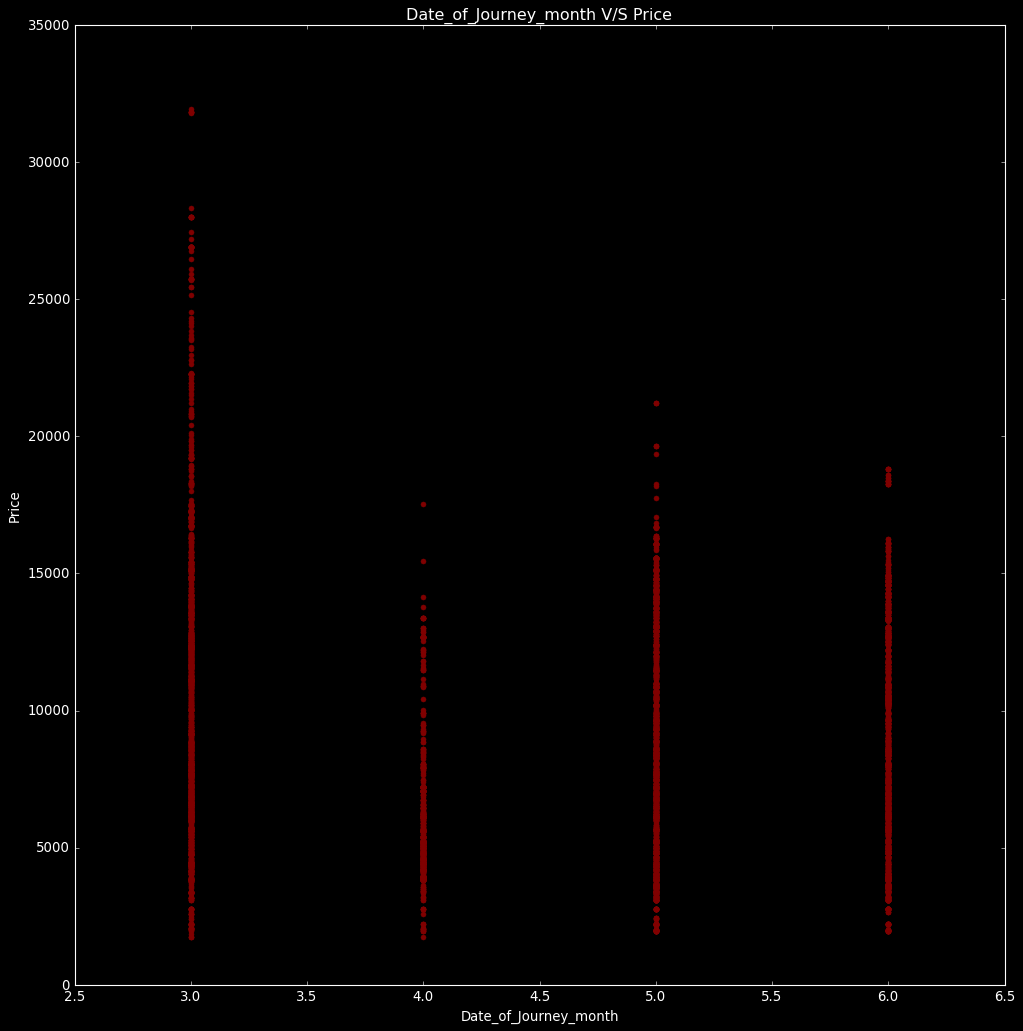

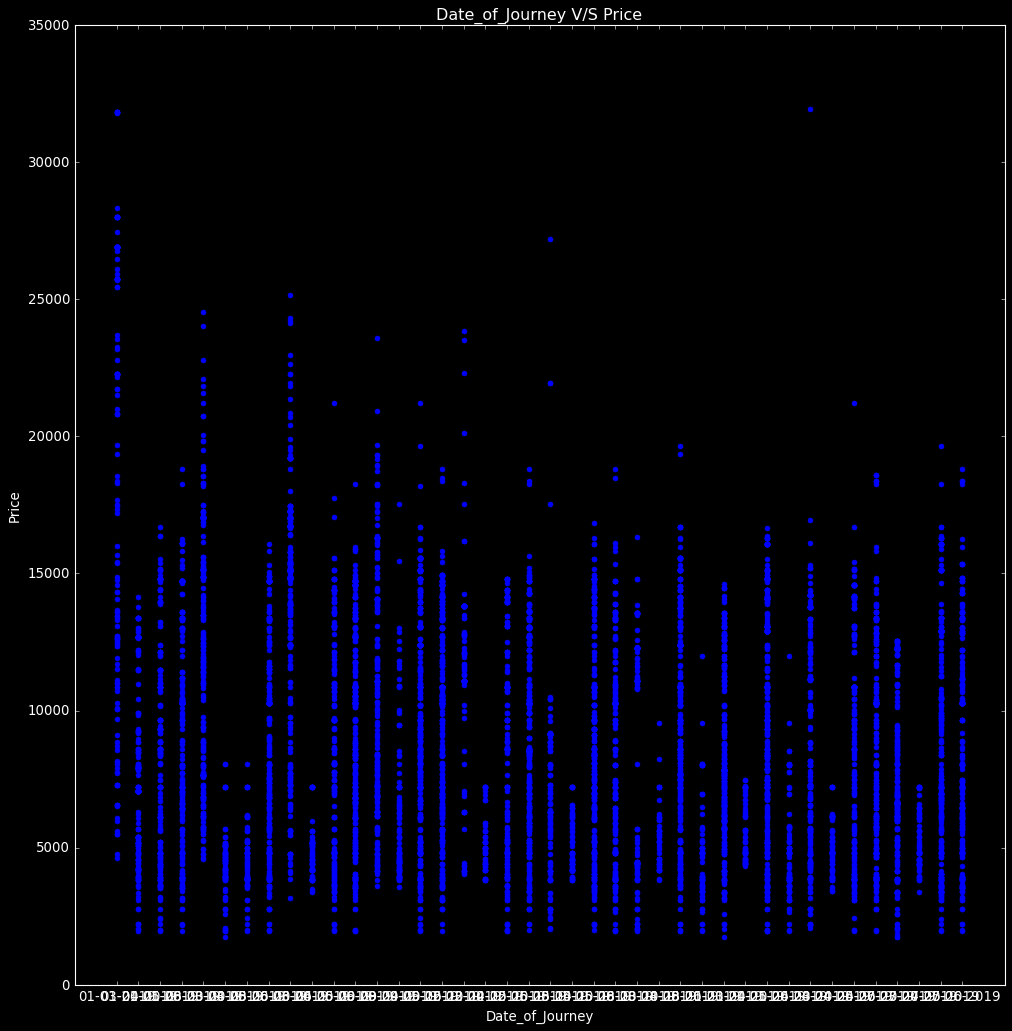

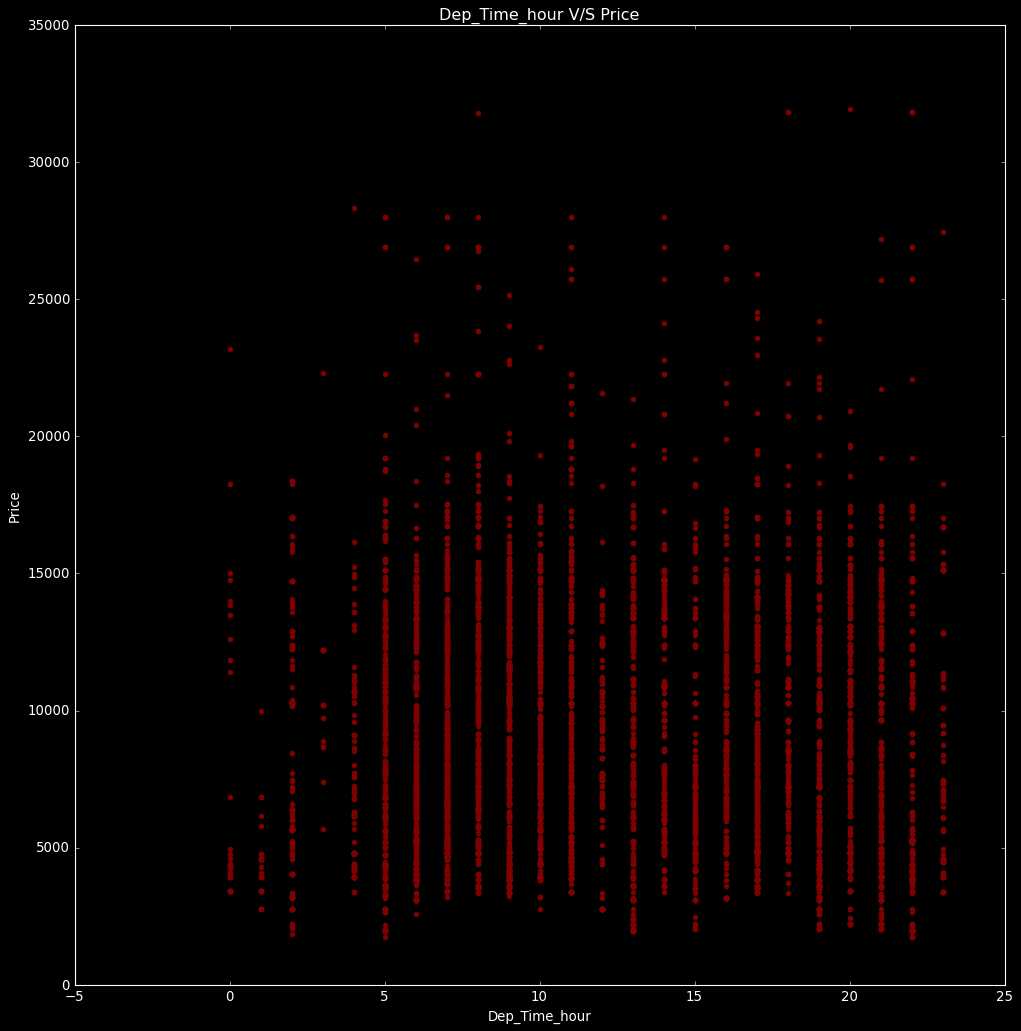

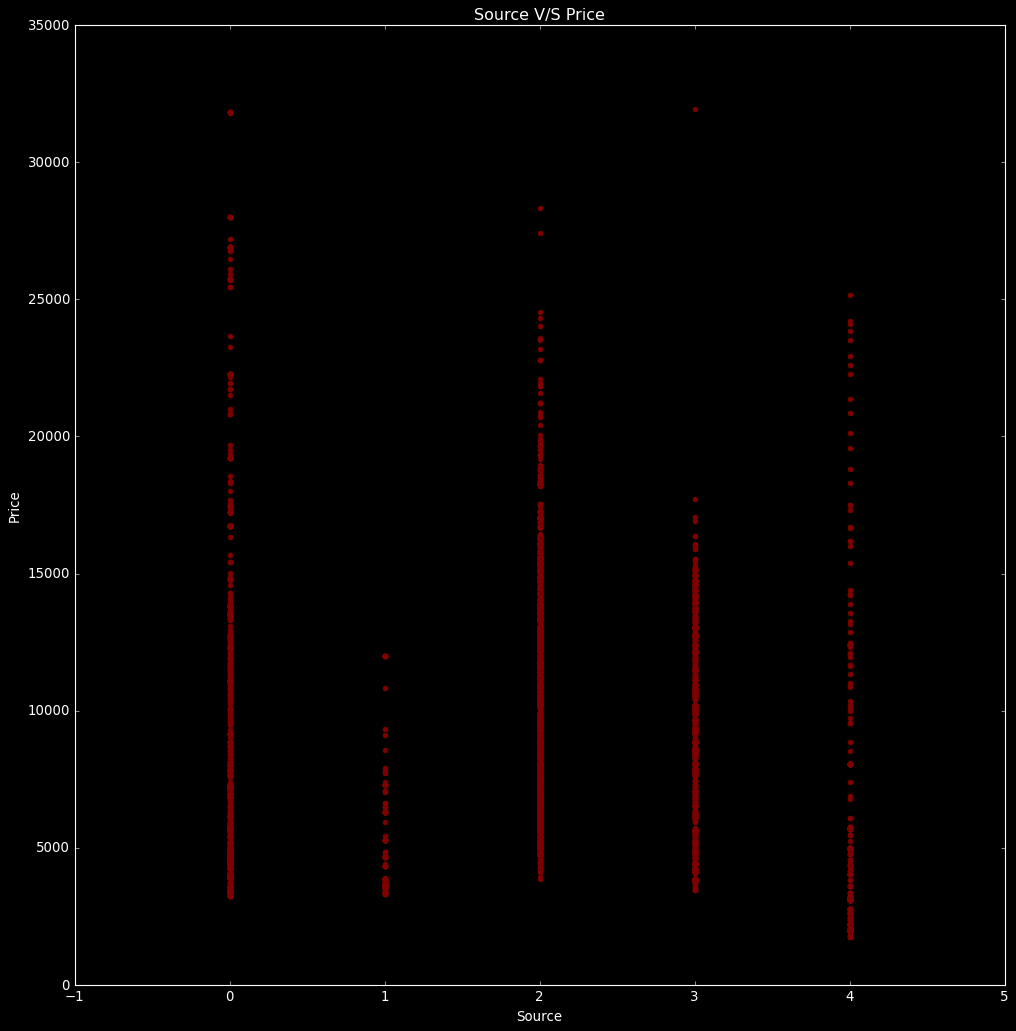

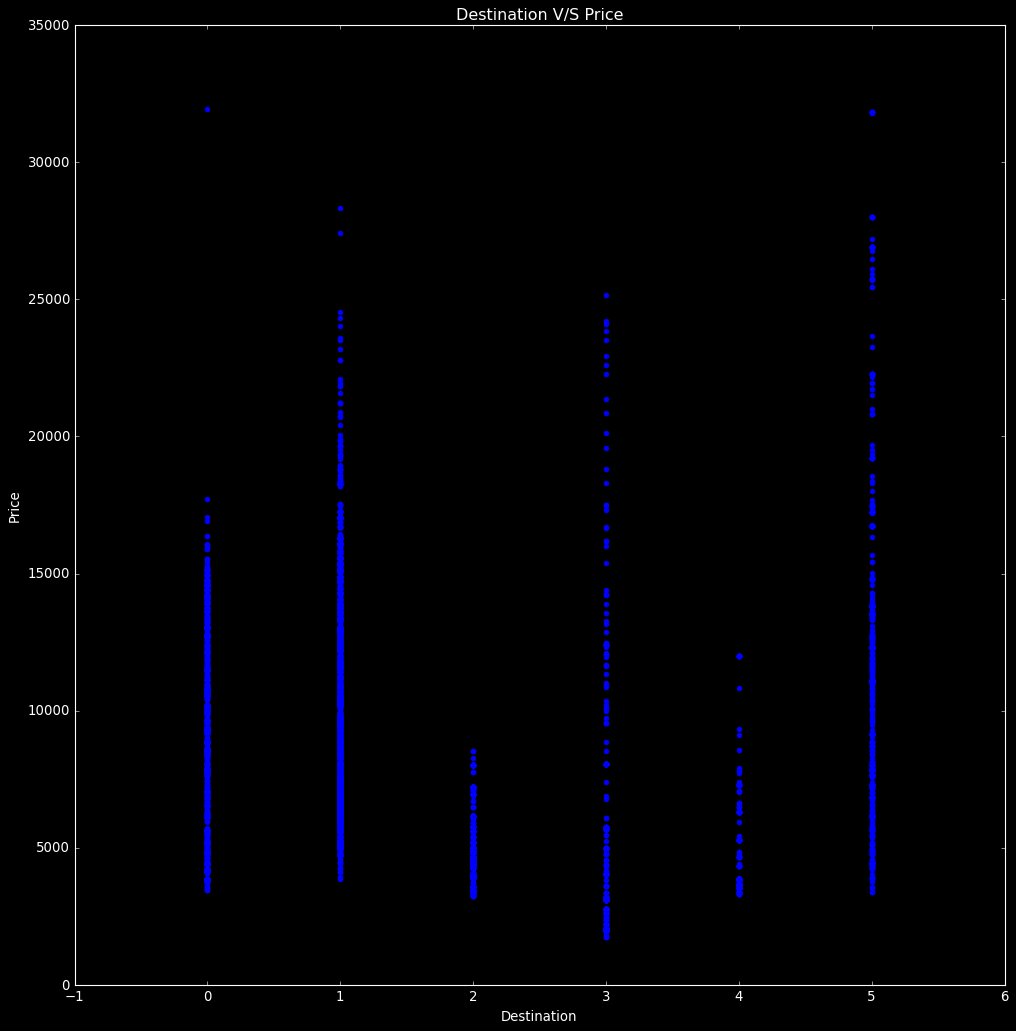

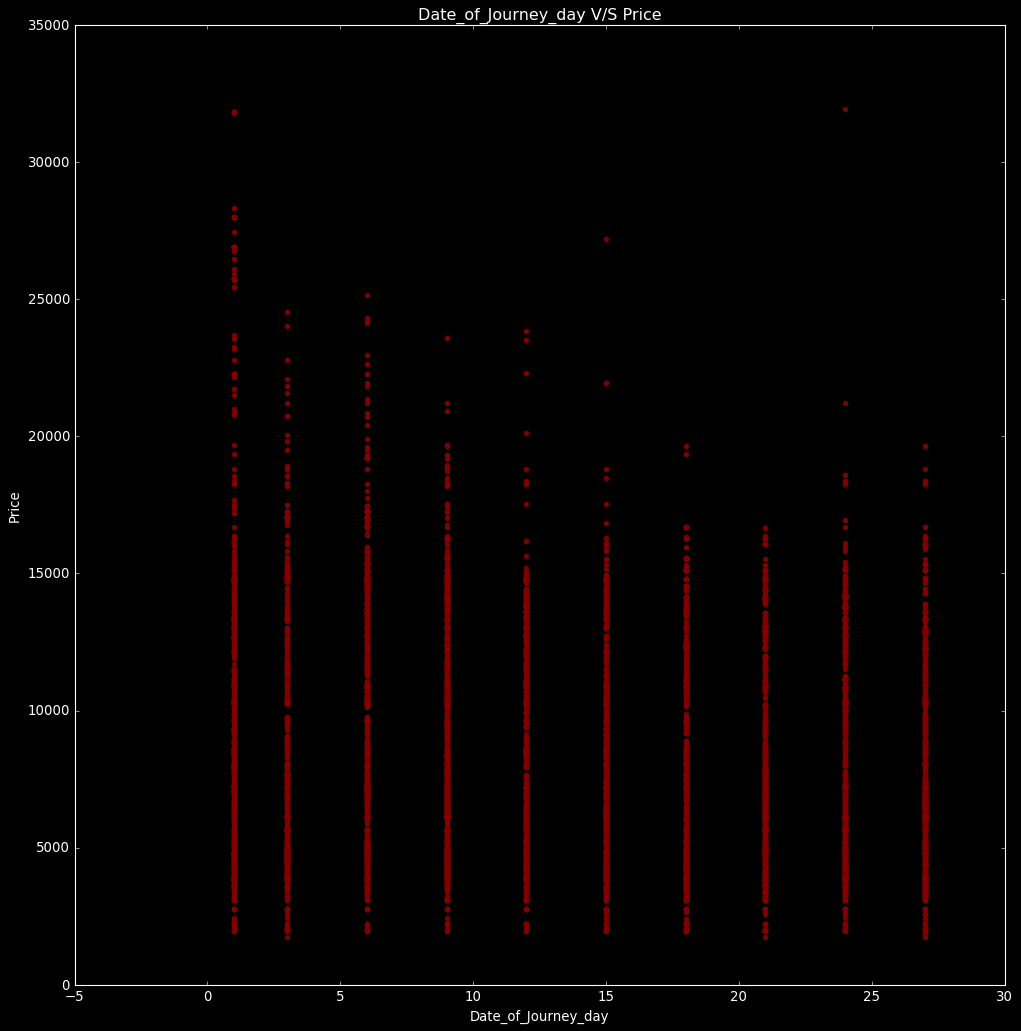

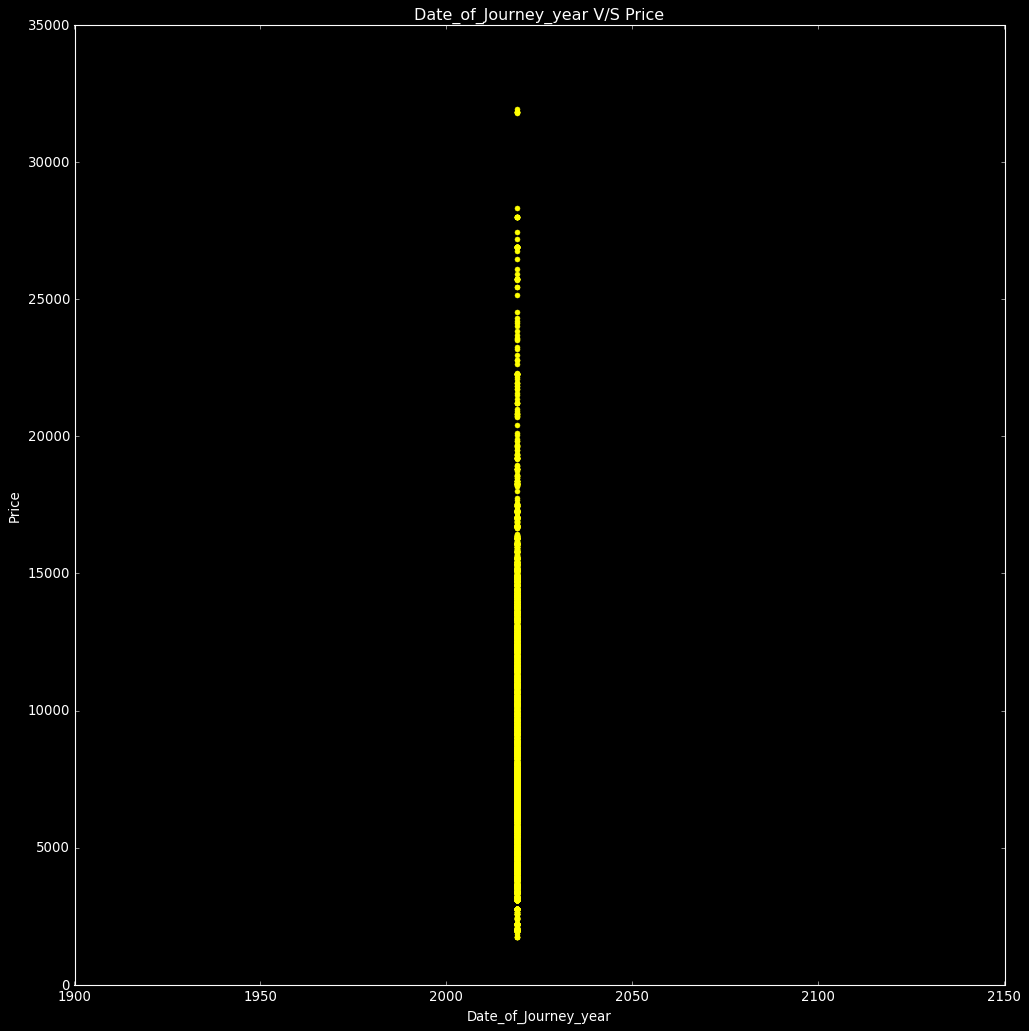

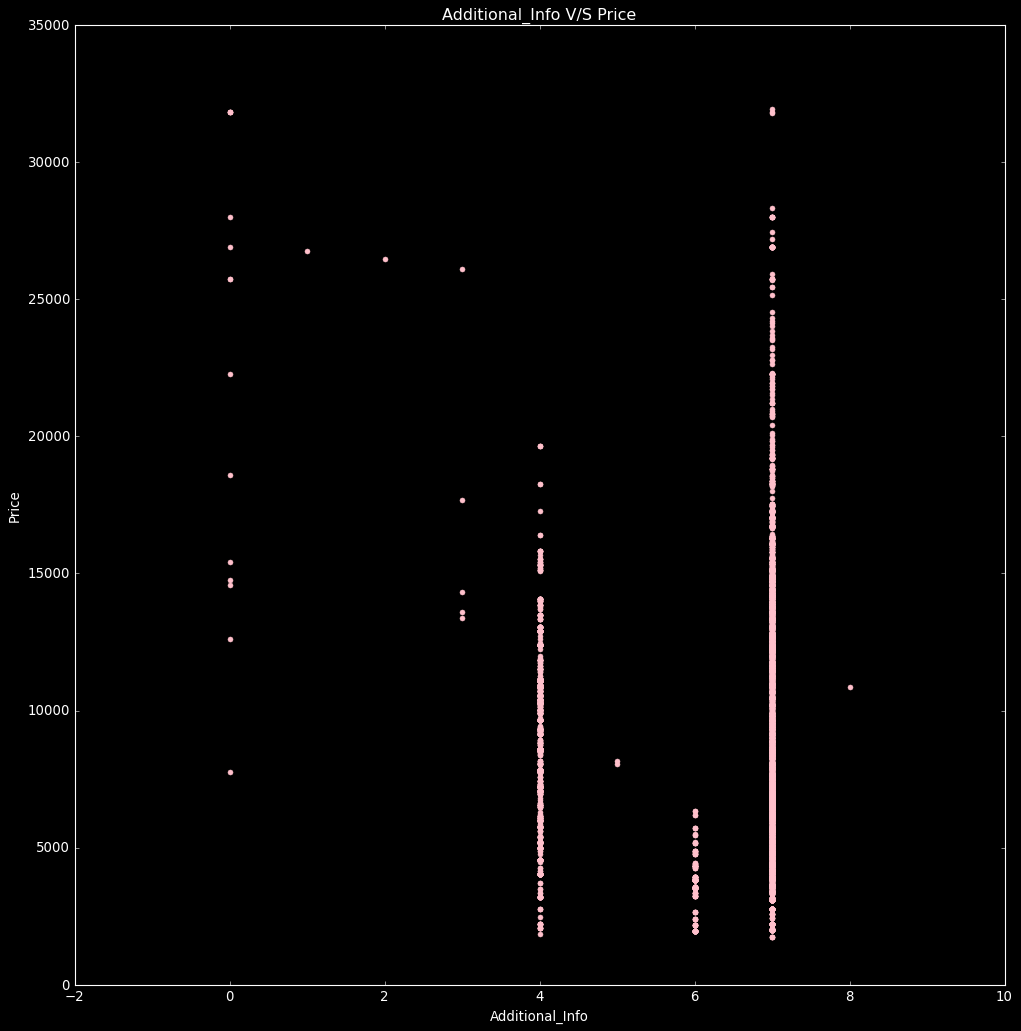

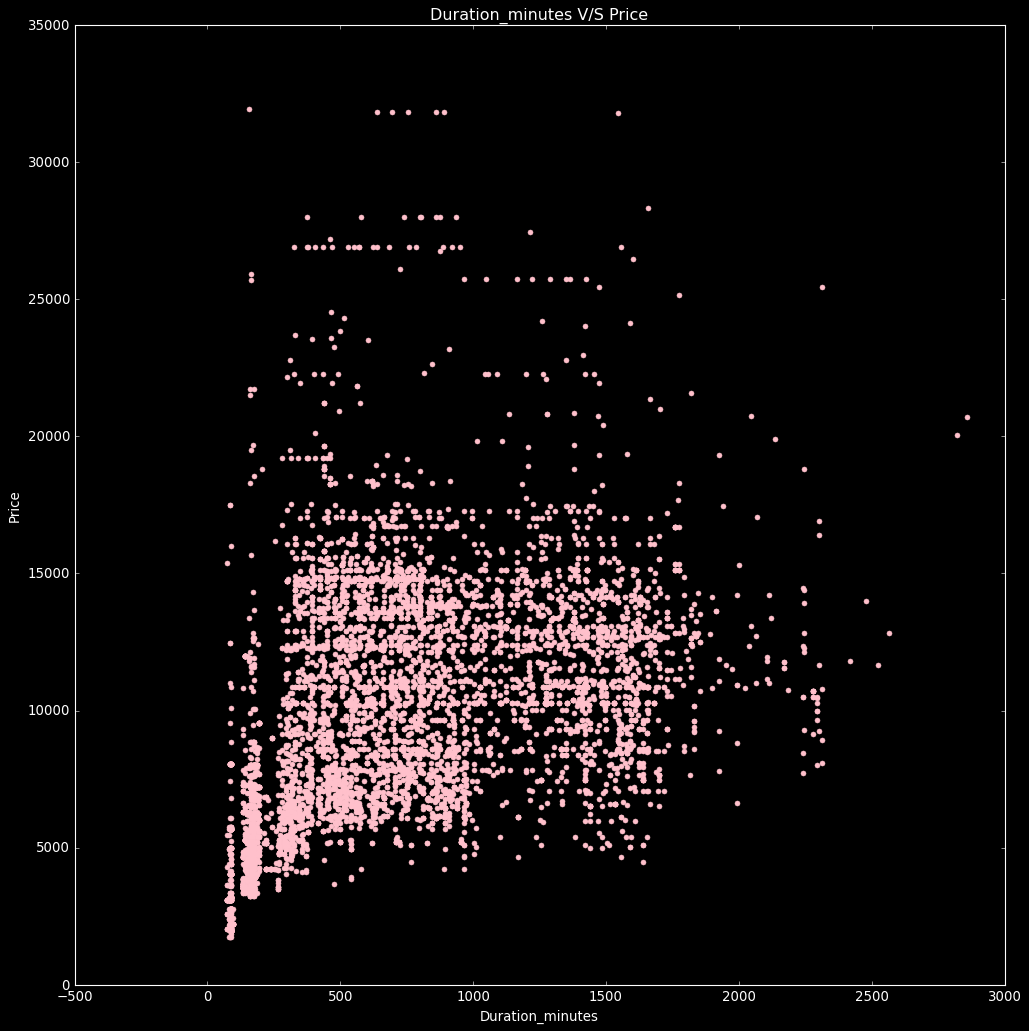

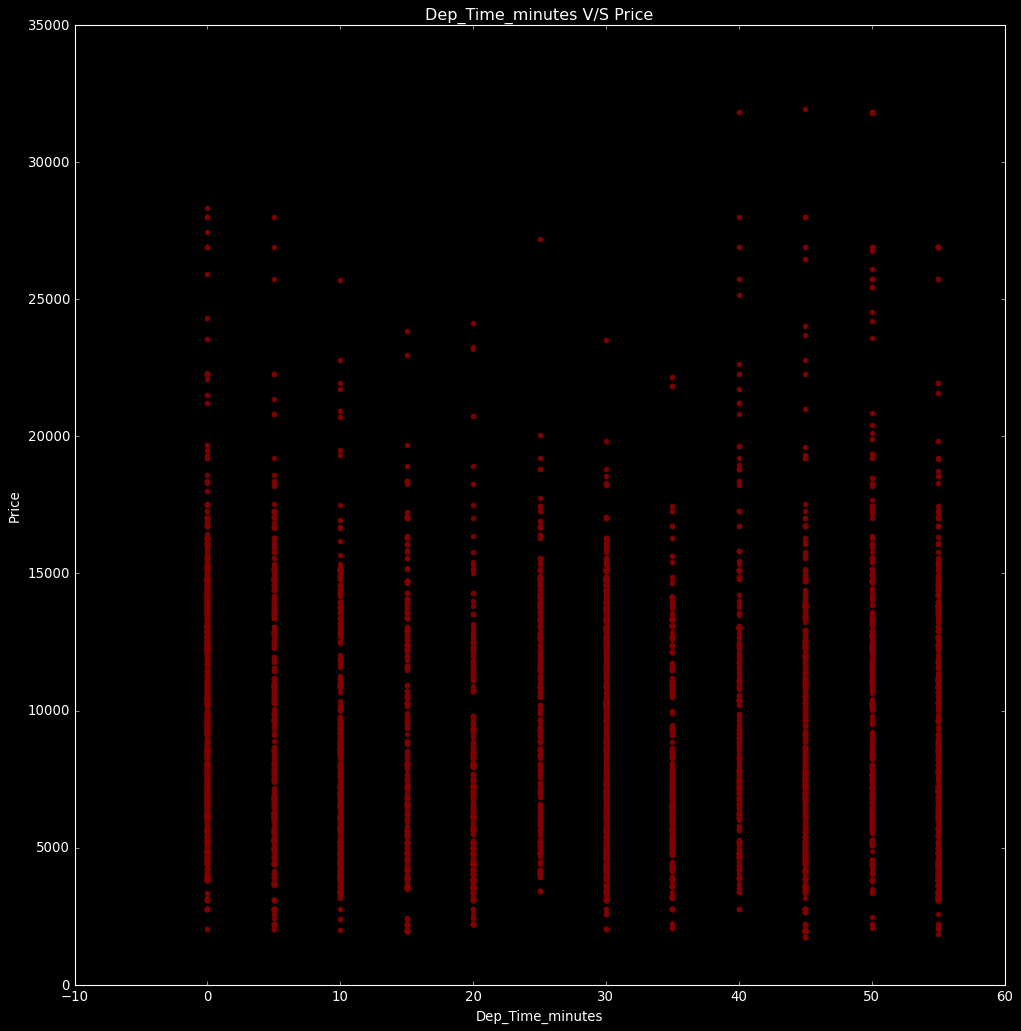

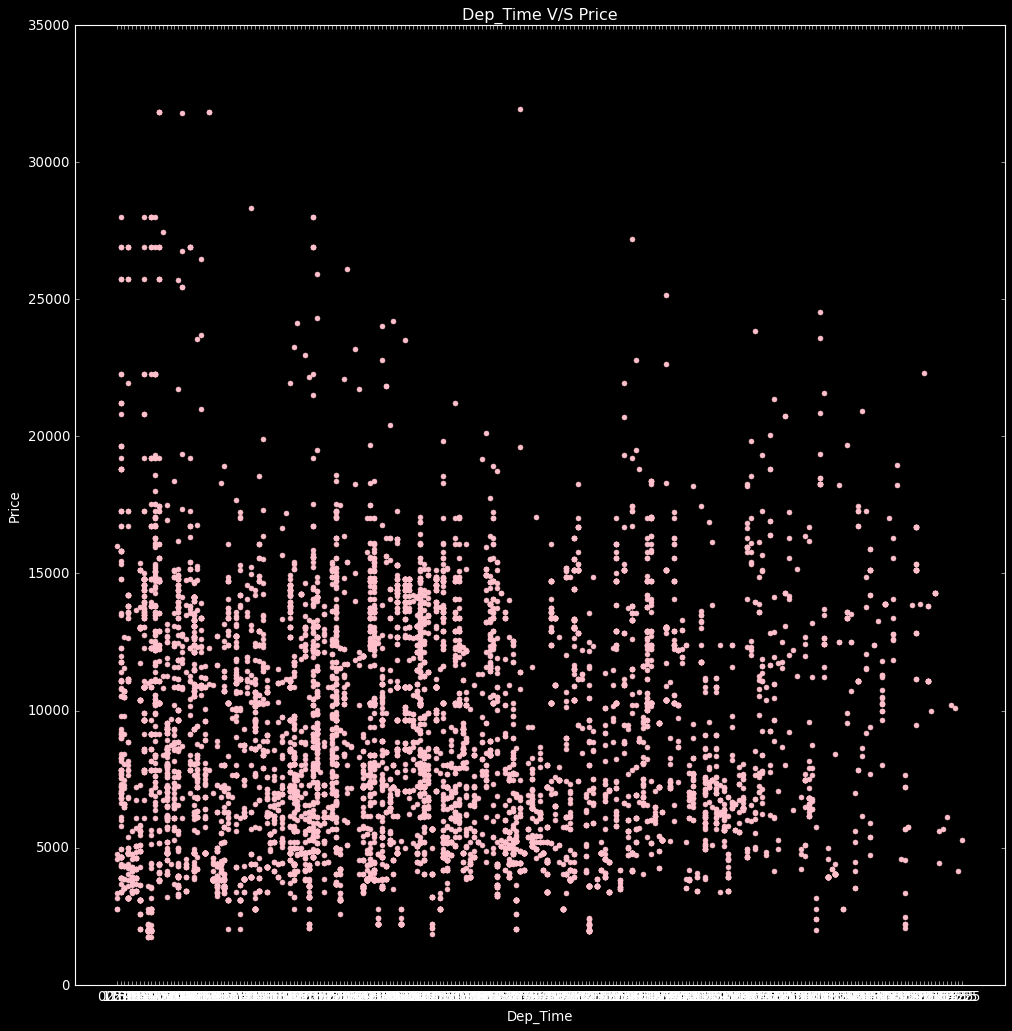

In [35]:
x_val = list(set(train_data.columns) - set(['Price']))
y_val = 'Price'
for col in x_val:
    plt.style.use('dark_background')
    plt.figure(figsize=(15,15))
    plt.scatter(train_data[col],train_data['Price'],color=random.sample(['yellow','maroon','blue','pink'],1),linewidth = .5)
    plt.title('{} V/S {}'.format(col,y_val))
    plt.xlabel(col)
    plt.ylabel(y_val)
    plt.show()

### DISTRIBUTION PLOTS

In [36]:
data = train_data.copy()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


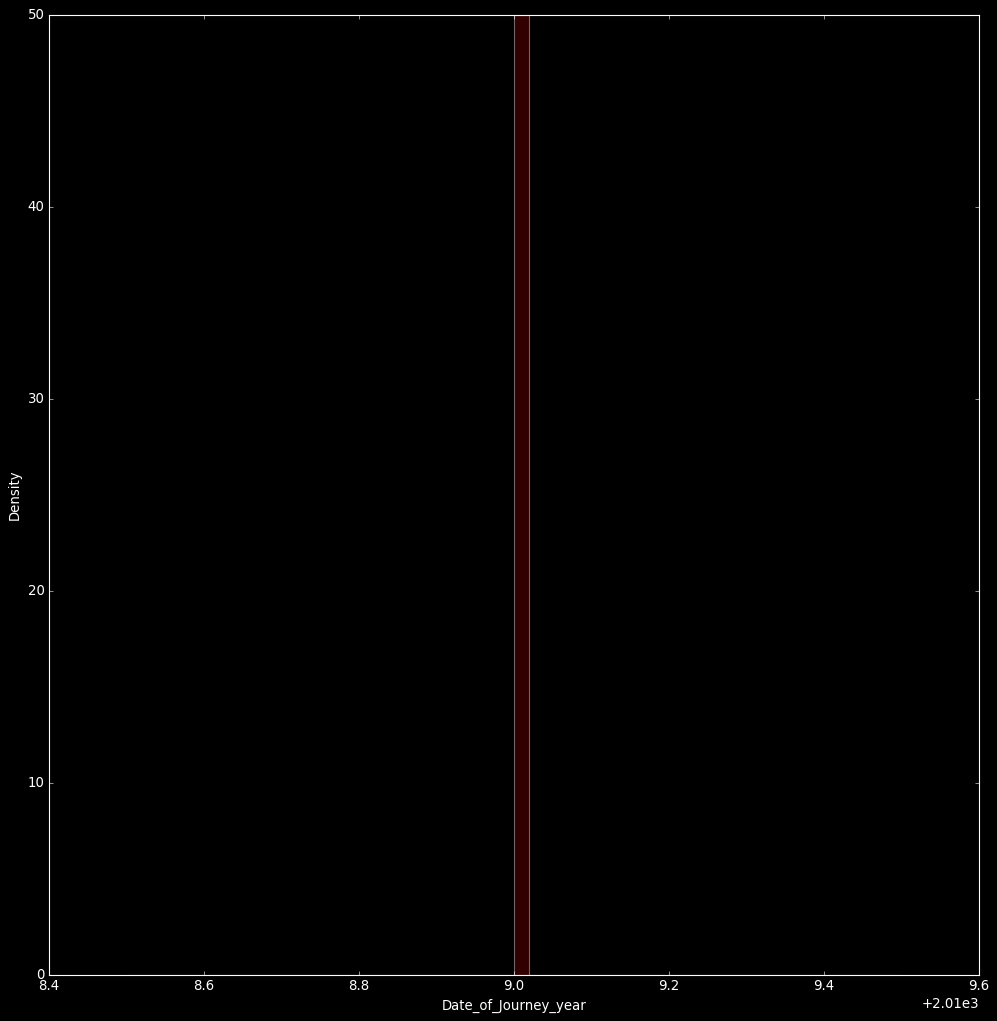

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


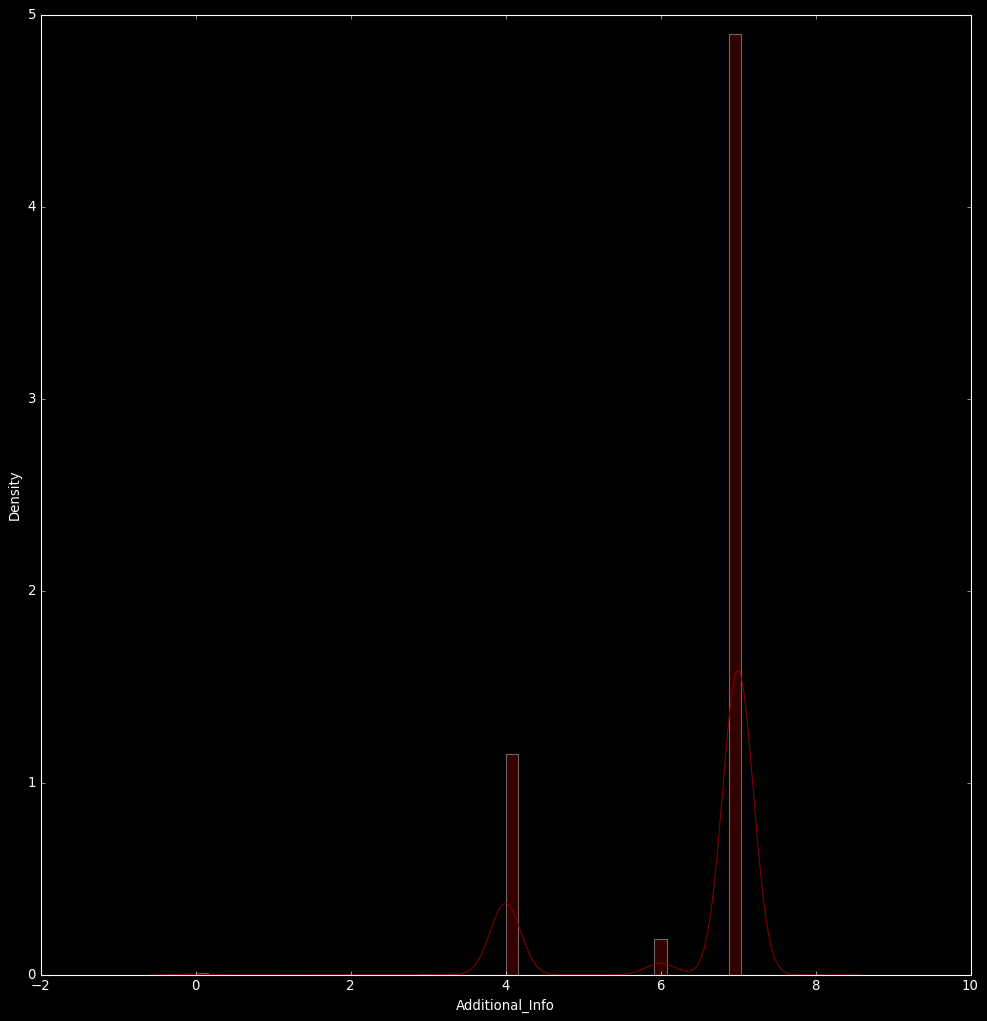

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


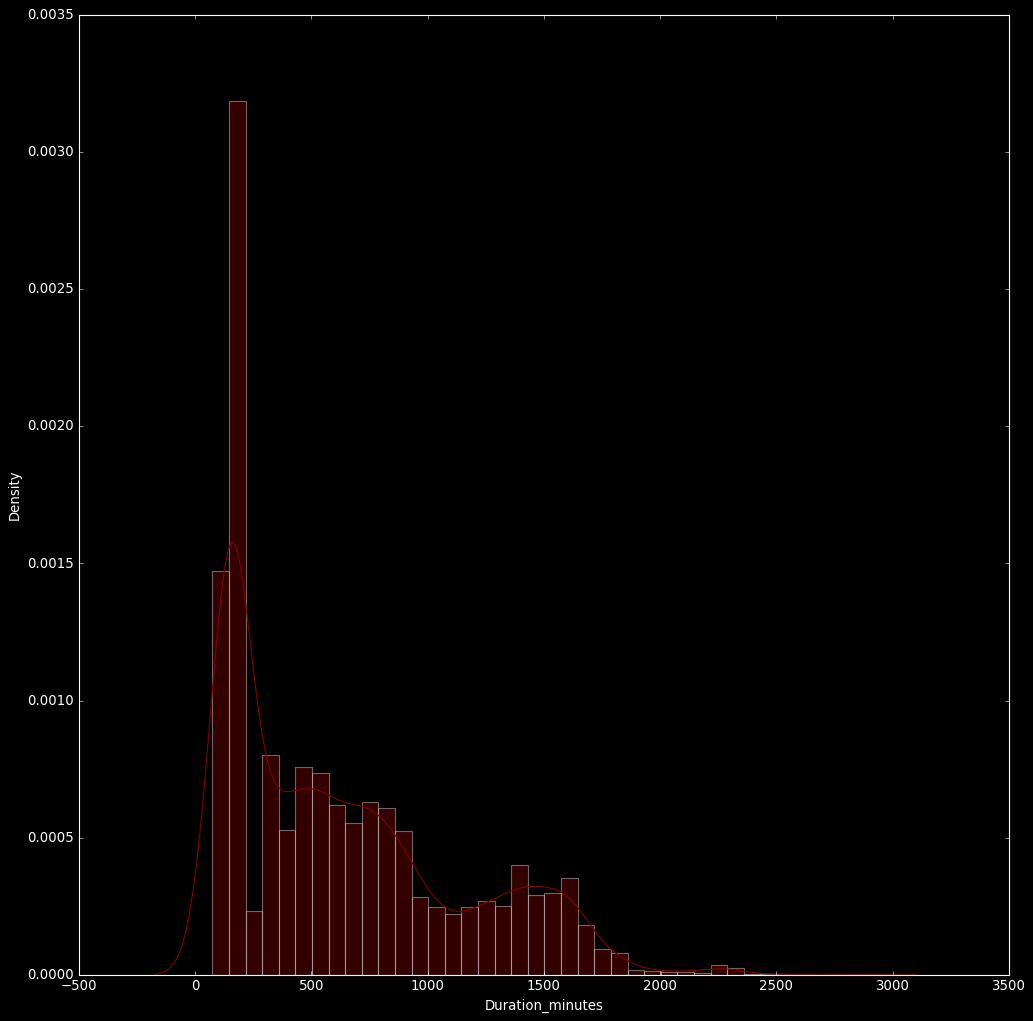

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


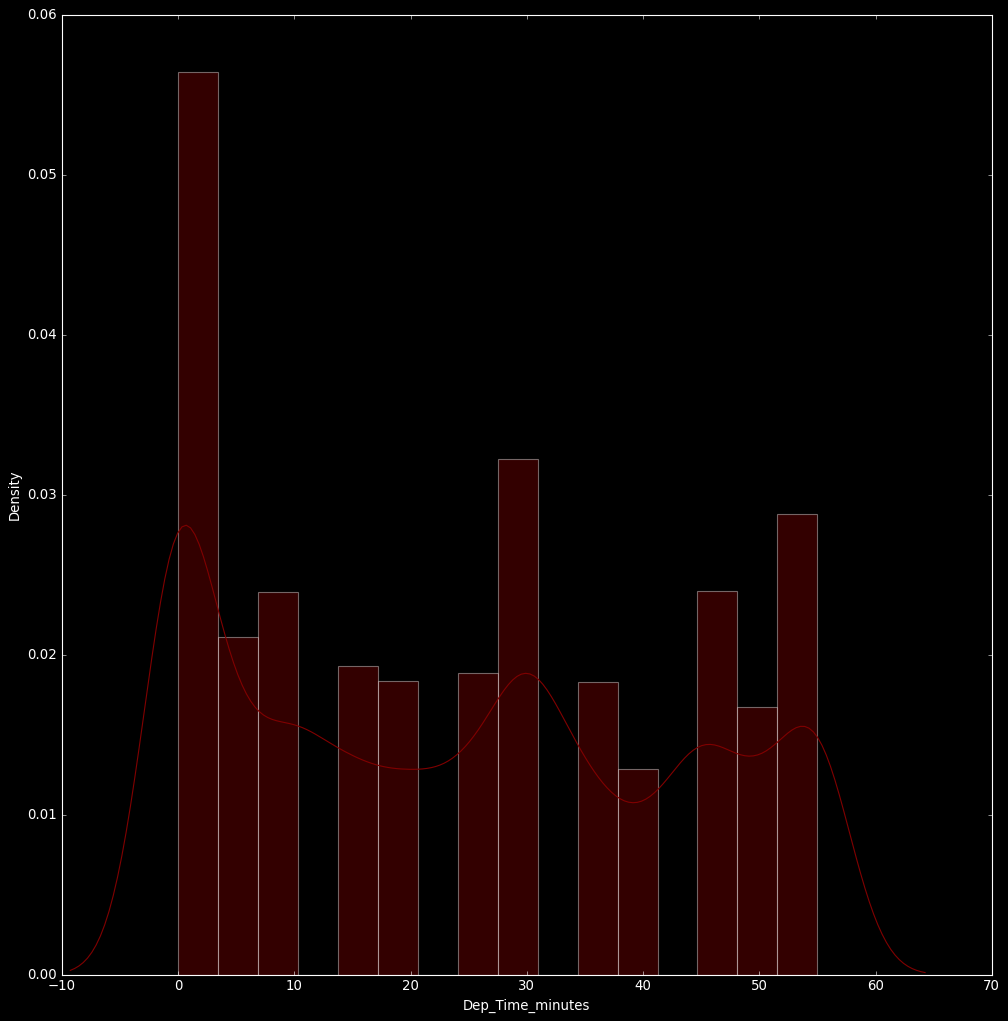

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


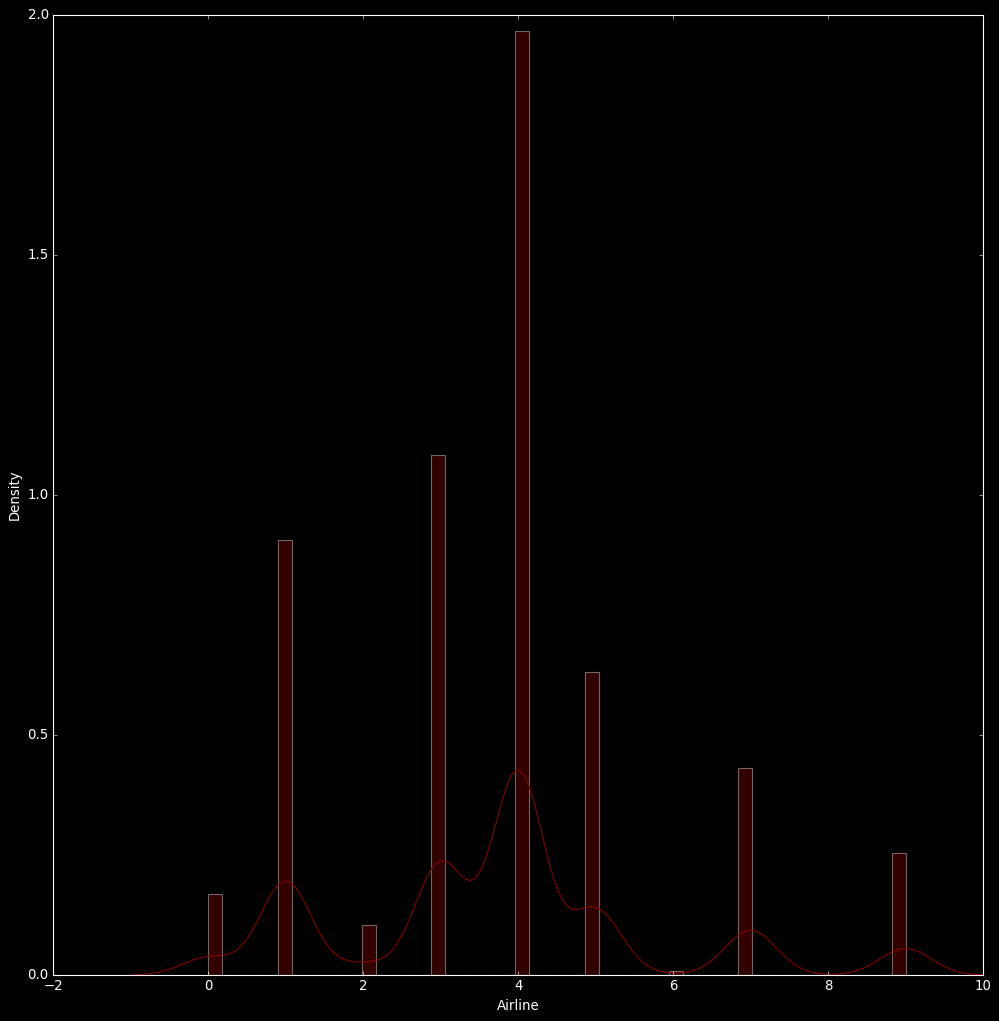

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


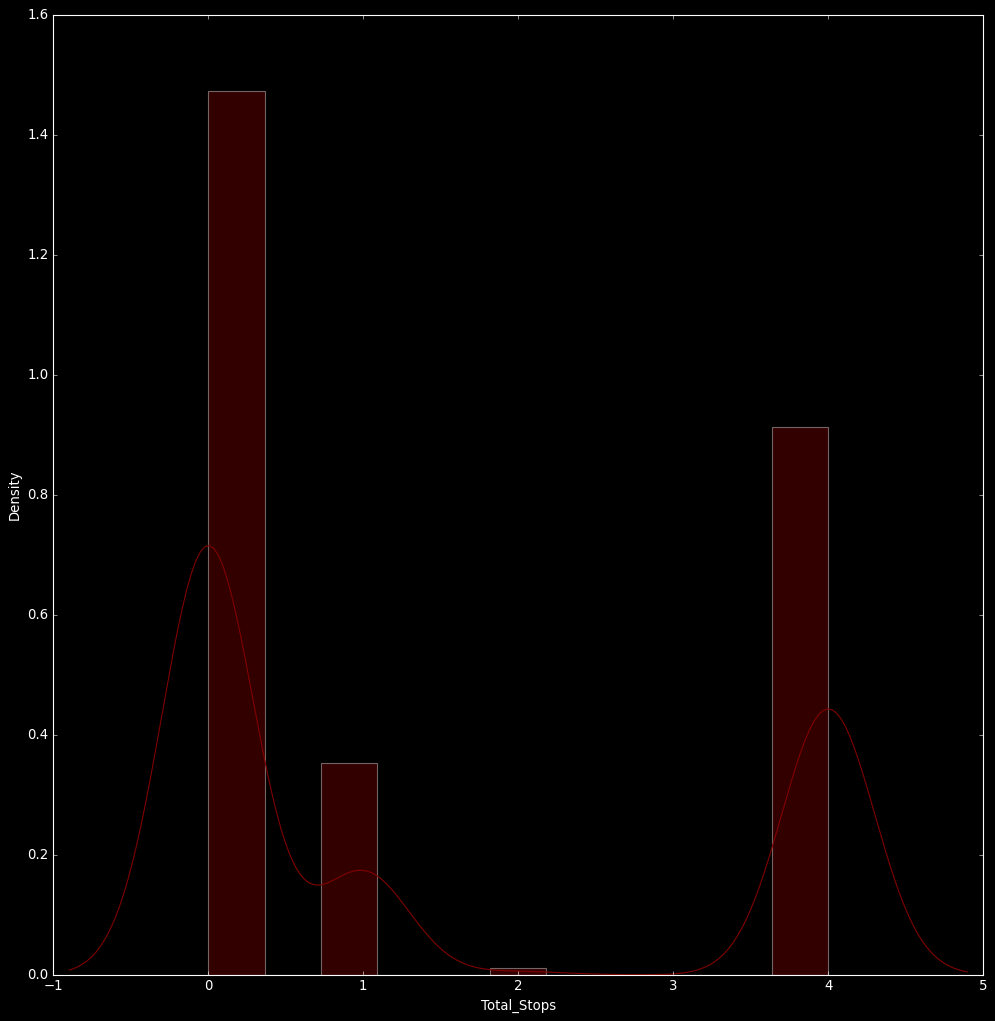

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


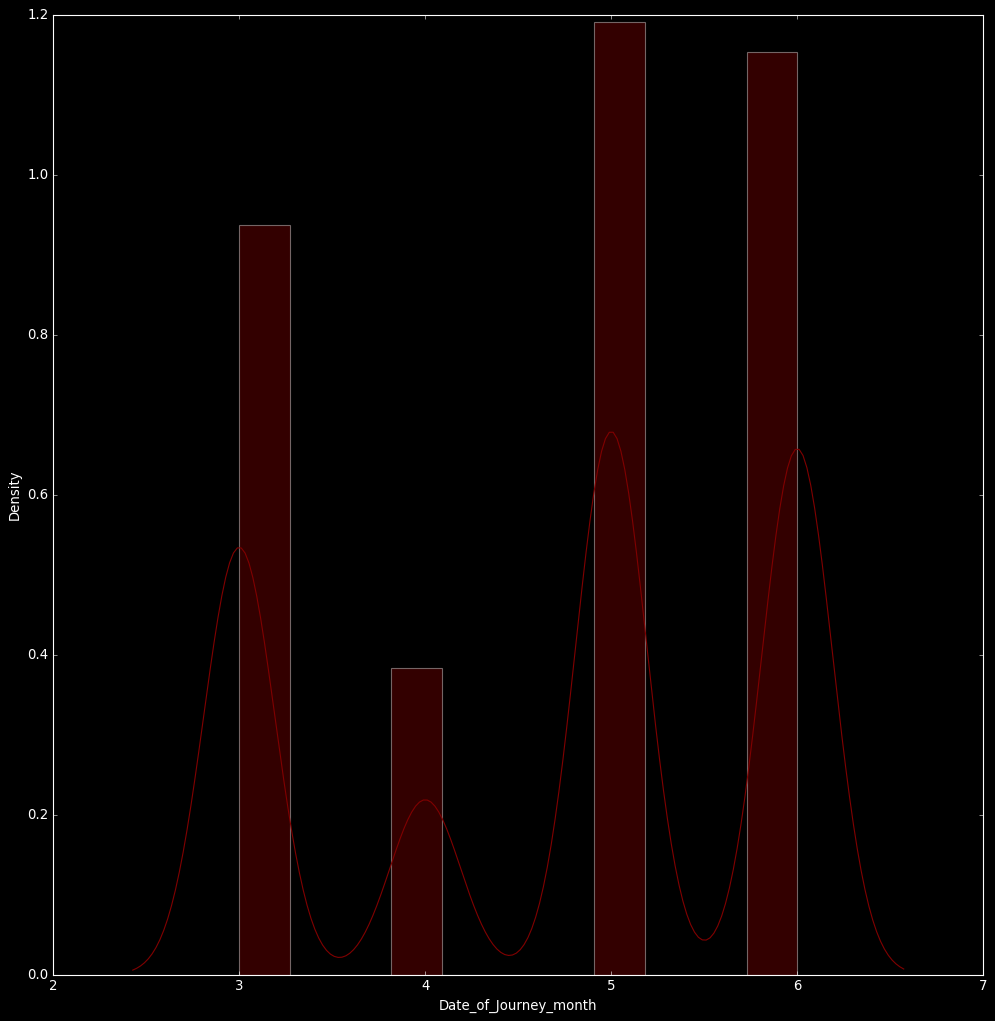

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


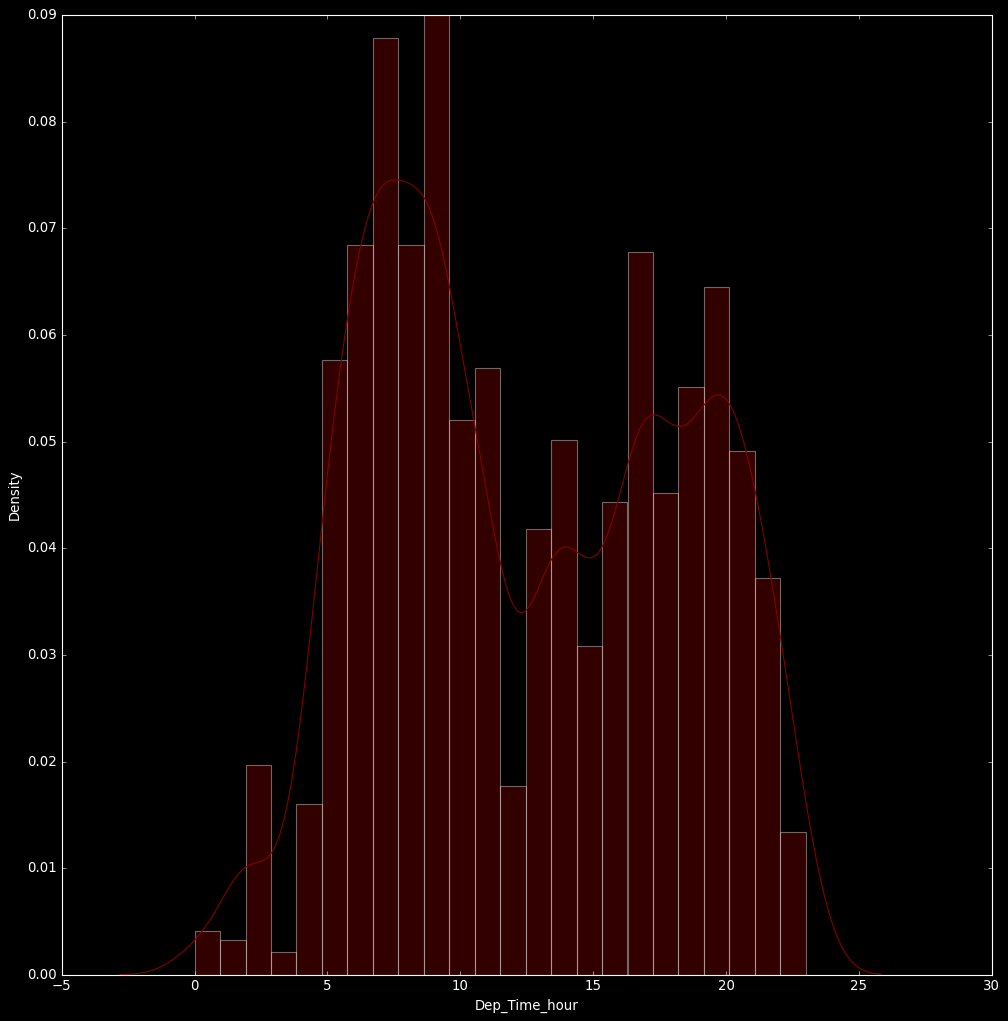

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


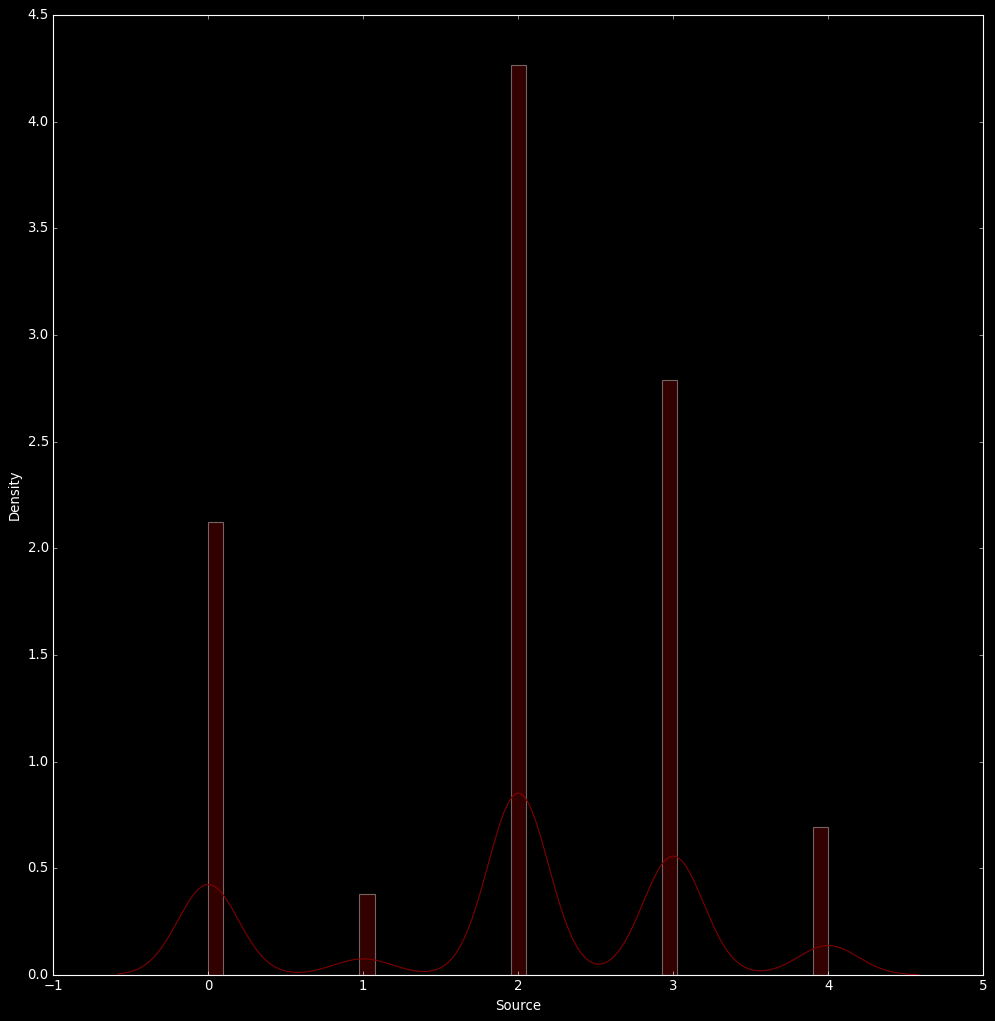

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


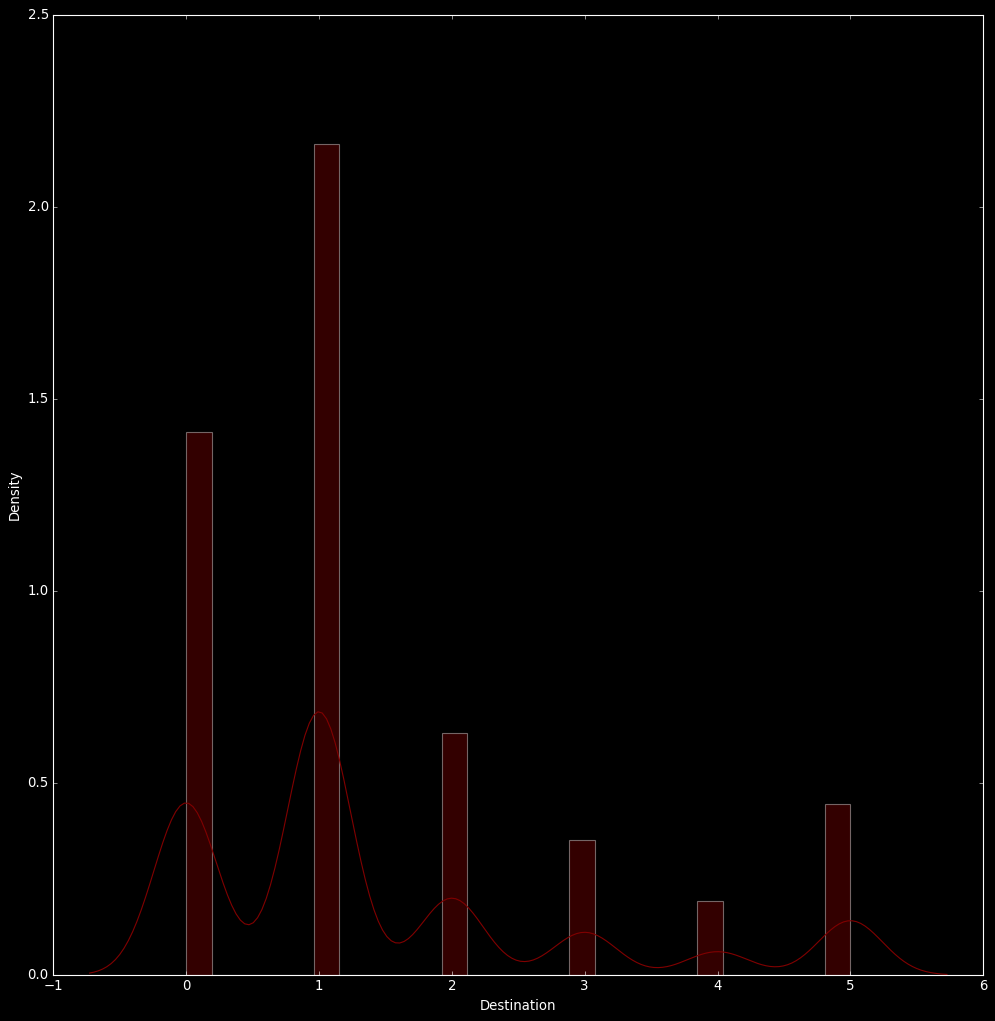

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


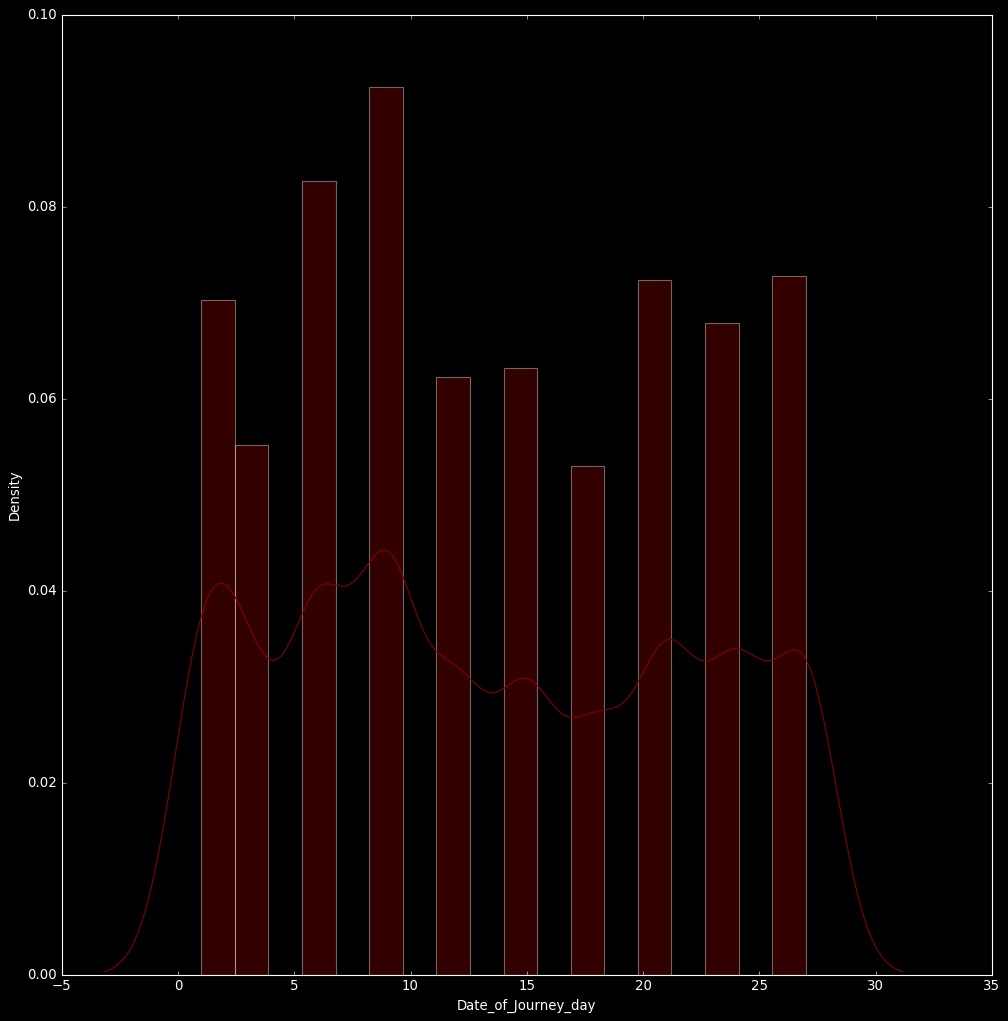

In [37]:
for col in list(set(data.columns) - set(['Price','Date_of_Journey','Dep_Time','Arrival_Time','Duration'])):
    plt.figure(figsize=(15,15))
    seaborn.distplot(data[col],color='maroon')
    plt.show()

### FEATURE ENGINEERING AND FEATURE GENERATION

In [38]:
train_data1 = train_data.copy()
test_data1 = test_data.copy()

In [39]:
def mode(a):
    u, c = np.unique(a, return_counts=True)
    return u[c.argmax()]

In [40]:
airline_mean = train_data.groupby('Airline').mean().round()
src_mean = train_data.groupby('Source').mean().round()
des_mean = train_data.groupby('Destination').mean().round()

airline_mean_test = test_data.groupby('Airline').mean().round()
src_mean_test = test_data.groupby('Source').mean().round()
des_mean_test = test_data.groupby('Destination').mean().round()


In [41]:
train_data.columns = ['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Dep_Time','Arrival_Time', 'Duration', 'Total_Stops', 'Additional_Info', 'Price','Date_of_Journey_month', 'Date_of_Journey_day', 'Date_of_Journey_year','Dep_Time_hour', 'Dep_Time_minutes', 'Duration_minutes']
test_data.columns = ['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Total_Stops','Additional_Info', 'Date_of_Journey_month', 'Date_of_Journey_day','Date_of_Journey_year', 'Dep_Time_hour', 'Dep_Time_minutes','Duration_minutes']

### EXTRACTING MORE INFO FROM THE DEPARTURE DATE AND TIME

In [42]:
train_data.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Dep_Time',
       'Arrival_Time', 'Duration', 'Total_Stops', 'Additional_Info', 'Price',
       'Date_of_Journey_month', 'Date_of_Journey_day', 'Date_of_Journey_year',
       'Dep_Time_hour', 'Dep_Time_minutes', 'Duration_minutes'],
      dtype='object')

In [43]:
# Chech the time of the day - Morning,Evening,etc
def time_of_day(x):
    if (x > 4) and (x <= 8):
        #'Early Morning'
        return 0
    elif (x > 8) and (x <= 12 ):
        # 'Morning'
        return 1
    elif (x > 12) and (x <= 16):
        # Noon
        return 2
    elif (x > 16) and (x <= 20) :
        #'Eve'
        return 3
    elif (x > 20) and (x <= 24):
        # 'Night'
        return 4
    elif (x <= 4):
        # 'Late Night'
        return 5


In [44]:
def check_is_holiday(x):
    if x not  in holiday_lis:
        return 0
    else: return 1
    
#train_data['Date_of_Journey'].apply(lambda x: check_is_holiday(x))

In [45]:
def check_month_time(x):
    if x in range(1,10):
        return 0
    elif x in range(10,20):
        return 1 
    else: 
        return 2

In [46]:
def is_month_end(x):
    if x<5 or x>25:
        return 1
    else:
        return 0

In [47]:
holiday_lis = []
holiday_season = {}
holiday_season_lis = []

for date in holidays.UnitedStates(years = train_data['Date_of_Journey_year'].unique()).items():
    holiday_lis.append(str(date[0]))
    holiday_season['Start'] = date[0]-datetime.timedelta(days=7)
    holiday_season['End'] = date[0]+datetime.timedelta(days=7)
    holiday_season_lis.append(holiday_season)
    

In [48]:
holiday_lis =  list(holidays.India(years= [2018,2019,2020]))
holiday_lis.extend(list(holidays.UnitedStates(years= [2018,2019,2020])))
holiday_lis.extend(list(holidays.England(years= [2018,2019,2020])))

In [49]:
train_data['IsWeekEnd'] = np.where((pd.to_datetime(train_data['Date_of_Journey'],format='%d-%m-%Y').dt.dayofweek) < 5,0,1) 
train_data['TimeOfDay'] = train_data['Dep_Time_hour'].apply(time_of_day)
train_data['TimeOfMonth'] = train_data['Date_of_Journey_day'].apply(lambda x: check_month_time(x))
train_data['WeekDay'] = pd.to_datetime(train_data['Date_of_Journey'],format='%d-%m-%Y').dt.dayofweek

test_data['IsWeekEnd'] = np.where((pd.to_datetime(test_data['Date_of_Journey'],format='%d-%m-%Y').dt.dayofweek) < 5,0,1) 
test_data['TimeOfDay'] = test_data['Dep_Time_hour'].apply(time_of_day)
test_data['TimeOfMonth'] = test_data['Date_of_Journey_day'].apply(lambda x: check_month_time(x))
test_data['WeekDay'] = pd.to_datetime(train_data['Date_of_Journey'],format='%d-%m-%Y').dt.dayofweek

train_data['IsMonthEnd'] = train_data['Date_of_Journey_day'].apply(lambda x: is_month_end(x))
test_data['IsMonthEnd'] = test_data['Date_of_Journey_day'].apply(lambda x: is_month_end(x))

In [50]:
set(train_data.columns) - set(test_data.columns)

{'Arrival_Time', 'Dep_Time', 'Duration', 'Price'}

In [51]:
train_data = train_data.drop(columns = {'Arrival_Time', 'Dep_Time', 'Duration'})

In [52]:
train_data = train_data.drop(columns = {'Date_of_Journey'})
test_data = test_data.drop(columns = {'Date_of_Journey'})

In [53]:
train_data = train_data.drop(columns = {'Date_of_Journey_year'})
test_data = test_data.drop(columns = {'Date_of_Journey_year'})

In [54]:
x_data = train_data[set(train_data.columns)-set(['Price'])] 
y_data = pd.DataFrame(train_data['Price'])

In [55]:
x_data

,Total_Stops,Airline,Date_of_Journey_month,Dep_Time_hour,Source,Destination,TimeOfDay,Date_of_Journey_day,IsWeekEnd,Additional_Info,WeekDay,Duration_minutes,Dep_Time_minutes,IsMonthEnd,TimeOfMonth
0,4,3,3,2,4,3,5,1,0,7,4,90,30,1,0
1,0,4,3,11,0,5,1,1,0,7,4,1200,40,1,0
2,0,3,3,5,0,5,0,1,0,5,4,285,15,1,0
3,4,3,3,16,0,5,2,1,0,7,4,170,55,1,0
4,4,3,3,5,1,4,0,1,0,7,4,140,15,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8381,1,1,6,16,2,1,2,27,0,7,3,1595,40,1,2
8382,0,3,6,10,2,1,1,27,0,7,3,625,35,1,2
8383,1,4,6,23,2,1,4,27,0,7,3,1760,5,1,2
8384,4,3,6,4,0,2,5,27,0,7,3,170,0,1,2


In [56]:
y_data

,Price
0,16000.0
1,22270.0
2,8064.0
3,12649.0
4,7295.0
...,...
8381,9653.0
8382,5894.0
8383,15339.0
8384,3943.0


### ONE-HOT ENCODING THE CATEGORICAL FEATURES

In [57]:
categorical_features = set(x_data.columns)
numerical_features = ['Duration_minutes']

In [58]:
x_data_c = pd.get_dummies(x_data[categorical_features],columns =categorical_features )
x_test_c = pd.get_dummies(test_data[categorical_features],columns =categorical_features )

In [59]:
x_data_c.shape,x_test_c.shape

((8386, 466), (2134, 396))

In [60]:
x_test_missing = list(set(x_data_c.columns) - set(x_test_c.columns))
x_test_missing

['Duration_minutes_1845',
 'Duration_minutes_2185',
 'Duration_minutes_1205',
 'Duration_minutes_670',
 'Duration_minutes_1160',
 'Duration_minutes_1030',
 'Duration_minutes_410',
 'Duration_minutes_1135',
 'Duration_minutes_2420',
 'Duration_minutes_1650',
 'Duration_minutes_1780',
 'Duration_minutes_1505',
 'Duration_minutes_815',
 'Duration_minutes_1890',
 'Duration_minutes_680',
 'Duration_minutes_1710',
 'Duration_minutes_1235',
 'Duration_minutes_1670',
 'Duration_minutes_905',
 'Duration_minutes_1750',
 'Duration_minutes_1565',
 'Duration_minutes_2105',
 'Duration_minutes_220',
 'Duration_minutes_2000',
 'Duration_minutes_1660',
 'Duration_minutes_2135',
 'Duration_minutes_2040',
 'Duration_minutes_405',
 'Duration_minutes_2120',
 'Duration_minutes_235',
 'Duration_minutes_285',
 'Duration_minutes_1060',
 'WeekDay_3',
 'Duration_minutes_1510',
 'Duration_minutes_1035',
 'Duration_minutes_1940',
 'Duration_minutes_1770',
 'WeekDay_1',
 'Duration_minutes_1735',
 'Duration_minutes_

In [61]:
x_train_missing = list(set(x_test_c.columns) - set(x_data_c.columns) )
x_train_missing

['Duration_minutes_1910',
 'Additional_Info_9',
 'Duration_minutes_1675',
 'Duration_minutes_2230',
 'Duration_minutes_2345']

In [62]:
for col in x_test_missing:
    x_test_c[col] =  0

In [63]:
x_test_c= x_test_c.drop(columns = x_train_missing)

In [64]:
x_data_c.shape,x_test_c.shape

((8386, 466), (2134, 466))

### TEST - TRAIN - EVALUATION DATA SPLIT

In [65]:
x_train_c,x_eval_c = train_test_split(x_data_c,test_size=0.2,shuffle=False)
x_train_c.shape,x_eval_c.shape

((6708, 466), (1678, 466))

In [66]:
x_train,x_eval,y_train,y_eval = train_test_split(x_data,y_data,test_size=0.2,shuffle=False)
x_test = test_data

In [67]:
x_train_c.shape,y_train.shape,x_eval_c.shape,y_eval.shape,x_test_c.shape

((6708, 466), (6708, 1), (1678, 466), (1678, 1), (2134, 466))

### LOG TRANSFORMATION OF 'PRICE' COLUMN

In [68]:
y_train['Price'] = np.log(y_train['Price'])
y_eval['Price'] = np.log(y_eval['Price'])

### SCALING THE NUMERICAL FEATURES

In [69]:
x_train_n = x_train[numerical_features]
x_test_n = x_test[numerical_features]

In [70]:
x_test_n

,Duration_minutes
0,315
1,185
2,1000
3,145
4,150
...,...
2129,165
2130,855
2131,615
2132,1305


In [71]:
numerical_features = x_train_n.columns

In [72]:
x_s = MinMaxScaler()
y_s = MinMaxScaler()


x_train_n = pd.DataFrame(x_s.fit_transform(x_train_n),columns =numerical_features)
x_test_n = pd.DataFrame(x_s.fit_transform(x_test_n),columns =numerical_features)
x_eval_n = pd.DataFrame(x_s.fit_transform(x_eval[numerical_features]),columns =numerical_features)


y_train = pd.DataFrame(y_s.fit_transform(y_train),columns =['Price'])
y_eval = pd.DataFrame(y_s.fit_transform(y_eval),columns =['Price'])


In [73]:
x_train_n.shape

(6708, 1)

In [74]:
x_train_n.shape,x_test_n.shape,x_eval_n.shape,y_train.shape,y_eval.shape

((6708, 1), (2134, 1), (1678, 1), (6708, 1), (1678, 1))

### Merging the Categorical and Numerical Data

In [75]:
x_train = x_train_n.merge(x_train_c,left_index=True,right_index=True).reset_index(drop=True)
x_train.shape

(6708, 467)

In [76]:
x_eval = x_eval_n.merge(x_eval_c.reset_index(drop=True),left_index=True,right_index=True).reset_index(drop=True)
x_eval.shape

(1678, 467)

In [77]:
x_test =x_test_n.merge(x_test_c,left_index=True,right_index=True).reset_index(drop=True)
x_test.shape

(2134, 467)

In [78]:
x_train = x_train.drop(columns=['Duration_minutes'])
x_test = x_test.drop(columns=['Duration_minutes'])
x_eval = x_eval.drop(columns=['Duration_minutes'])

### MODEL TRAINING , PREDICTION AND EVALUATION

In [79]:
def evaluate_metrics(x,y_true,y_pred,mod):
    mean_abs_error = mean_absolute_error(y_true,y_pred)
    mean_sq_error = mean_squared_error(y_true,y_pred)
    root_mean_sq_error = mean_squared_error(y_true,y_pred)**0.5
    r2_scr = r2_score(y_true,y_pred)
    median_abs_score = median_absolute_error(y_true,y_pred)
    explained_variance = explained_variance_score(y_true,y_pred)
    return mean_abs_error,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance  

In [80]:
def plot_regression_line(x,y_t,y_p):
    plt.scatter(x,y_t,color='red',label = 'Y TRUE')
    plt.scatter(x,y_p,color='yellow',linewidth = 0.5,label = 'Y PREDICTED')
    #plt.xlim(-0.00000000000001,0.000000000000001)
    plt.xlabel('ENTRY NO.')
    plt.ylabel('PRICE')
    plt.legend()
    plt.title('ENTRY NO. V/S {} Regression Line\n'.format('delay'))
    plt.show()

In [81]:
def select_features(x_train,y_train,x_test,x_eval1,k):
    fs = SelectKBest(score_func = f_regression,k=k)
    fs.fit(x_train,y_train)
    col_indices = fs.get_support(indices=True)
    x_features = x_train.columns[col_indices]
    x_train_fs = pd.DataFrame(fs.transform(x_train),columns=x_features)
    x_test_fs = pd.DataFrame(fs.transform(x_test),columns=x_features)
    x_eval_fs = pd.DataFrame(fs.transform(x_eval1),columns=x_features)
    return x_train_fs,x_test_fs,x_eval_fs,fs,x_features,col_indices


x_train_fs,x_test_fs,x_eval_fs,fs,x_features,col_indices = select_features(x_train,y_train,x_test,x_eval,'all')

for i in range(len(fs.scores_[col_indices])):
    print("\n",x_features[i],"    ",fs.scores_[col_indices][i])
    


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms



 IsWeekEnd_0      15.638860628103561

 IsWeekEnd_1      15.63886062810405

 Additional_Info_0      49.343542988030876

 Additional_Info_1      5.387171222493433

 Additional_Info_2      5.298364154745457

 Additional_Info_3      9.464859562808847

 Additional_Info_4      59.59488844796331

 Additional_Info_5      2.0502465605591552e-05

 Additional_Info_6      544.4197145070143

 Additional_Info_7      0.3801618073437859

 Additional_Info_8      0.32811322068731535

 WeekDay_0      51.04939841585042

 WeekDay_1      1.8894686271285106

 WeekDay_2      24.62284325402979

 WeekDay_3      0.04919826269651595

 WeekDay_4      16.682405939287367

 WeekDay_5      0.20719598167618622

 WeekDay_6      23.492623248572304

 Duration_minutes_75      54.518434633120144

 Duration_minutes_80      105.67721246418962

 Duration_minutes_85      104.56437115440376

 Duration_minutes_90      944.0930820738806

 Duration_minutes_95      66.90851795771798

 Duration_minutes_135      111.54956242525012

 

In [82]:
reg_metrics = dict()
predicted_price = dict()

In [83]:
gc.collect()

8894

In [84]:
train_data.corr()['Price']

Airline                 -0.028410
Source                   0.030118
Destination             -0.096020
Total_Stops             -0.599452
Additional_Info         -0.060548
Price                    1.000000
Date_of_Journey_month   -0.101721
Date_of_Journey_day     -0.154805
Dep_Time_hour            0.004528
Dep_Time_minutes        -0.037425
Duration_minutes         0.540753
IsWeekEnd                0.034507
TimeOfDay               -0.054937
TimeOfMonth             -0.151694
WeekDay                  0.064349
IsMonthEnd               0.010252
Name: Price, dtype: float64

### 1. RIDGE REGRESSION

In [85]:
ridge = Ridge()
parameters = {'alpha':[x for x in [0.0005,0.0001,0.00021,0.0006,0.1,0.001,0.005,0.008,0.1,0.5,1,0.1,0.09,0.08,0.06,0.05,0.03,0.01,0.02,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.999,1]]}  

ridge_reg = GridSearchCV(ridge,param_grid = parameters,verbose=1)
ridge_reg = ridge_reg.fit(x_eval_fs,y_eval)

alpha = ridge_reg.best_params_['alpha']

print("\n\nBest Alpha:  ",ridge_reg.best_params_,"\nScore:  ",ridge_reg.best_score_)

ridge_mod = Ridge(alpha=alpha)
ridge_mod=ridge_mod.fit(x_train_fs,y_train)
y_pred = ridge_mod.predict(x_eval_fs)
mean_abs_error,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance = evaluate_metrics(x_eval_fs,y_eval,y_pred,ridge_mod)
scr = ridge_mod.score(x_eval_fs,y_eval)
print("\n\n\nMETRICS  :\n\nMean Absolute Error :  ",mean_abs_error,"\nScore :   ",scr,"\nMean Squared Error :  ",mean_sq_error,"\nRoot Mean Squared Error :  ",root_mean_sq_error,"\nR2 Square :  ",r2_scr,"\nMedian Absolute Score :  ",median_abs_score,"\nExplained Variance Score :  ",explained_variance)

Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:   41.4s finished




Best Alpha:   {'alpha': 1} 
Score:   0.7831267117742022



METRICS  :

Mean Absolute Error :   0.07455420307043056 
Score :    0.7006233920607172 
Mean Squared Error :   0.008624436221043448 
Root Mean Squared Error :   0.09286784277156139 
R2 Square :   0.7006233920607172 
Median Absolute Score :   0.062491347438662026 
Explained Variance Score :   0.7290686885312132


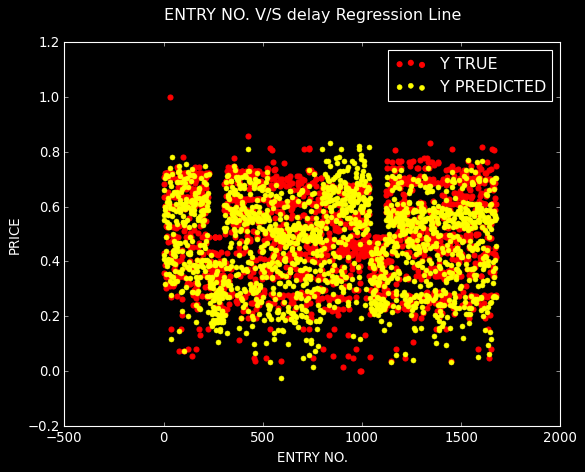

In [86]:
reg_metrics['RIDGE REGRESSION'] = [mean_abs_error,scr,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance]    
predicted_price['ridge_regression_price'] = np.exp(y_s.inverse_transform(ridge_mod.predict(x_test_fs))).reshape(ridge_mod.predict(x_test_fs).shape[0]).round()
plot_regression_line(x_eval_fs.index,y_eval,y_pred)

### 2. LASSO REGRESSION

In [87]:
y_eval= np.array(y_eval)

In [88]:
# Hyper Parameter tuning using the train data

lasso_reg = Lasso()
parameters = {'alpha':[x for x in [0.0005,0.0001,0.00021,0.0006,0.1,0.00071,0.00070,0.00072,0.00073,0.00079,0.1,0.5,1]]}  
lasso_reg = GridSearchCV(lasso_reg,param_grid=parameters,verbose=1)
lasso_reg.fit(x_train_fs,y_train)

print("\n\n\nBest Alpha : ",lasso_reg.best_params_,"\nBest Score : ",lasso_reg.best_score_)

lasso_reg = Lasso(alpha=0.0001)
lasso_reg = lasso_reg.fit(x_train_fs,y_train)
y_pred = np.array(lasso_reg.predict(x_eval_fs))

mean_abs_error,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance = evaluate_metrics(x_eval_fs,np.array(y_eval).reshape(y_eval.shape[0],1),y_pred.reshape(y_pred.shape[0],1),ridge_mod)
scr = lasso_reg.score(x_eval_fs,y_eval)
print("METRICS  :\n\nMean Absolute Error :  ",mean_abs_error,"\nScore :   ",scr,"\nMean Squared Error :  ",mean_sq_error,"\nRoot Mean Squared Error :  ",root_mean_sq_error,"\nR2 Square :  ",r2_scr,"\nMedian Absolute Score :  ",median_abs_score,"\nExplained Variance Score :  ",explained_variance)    

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03302662355761754, tolerance: 0.01729851615417848
  positive)
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:   20.7s finished





Best Alpha :  {'alpha': 0.0007} 
Best Score :  0.7220290370944658
METRICS  :

Mean Absolute Error :   0.06959626094947605 
Score :    0.7248741398447424 
Mean Squared Error :   0.007925821092040604 
Root Mean Squared Error :   0.08902708066673086 
R2 Square :   0.7248741398447424 
Median Absolute Score :   0.05799899015012683 
Explained Variance Score :   0.7325075654726174


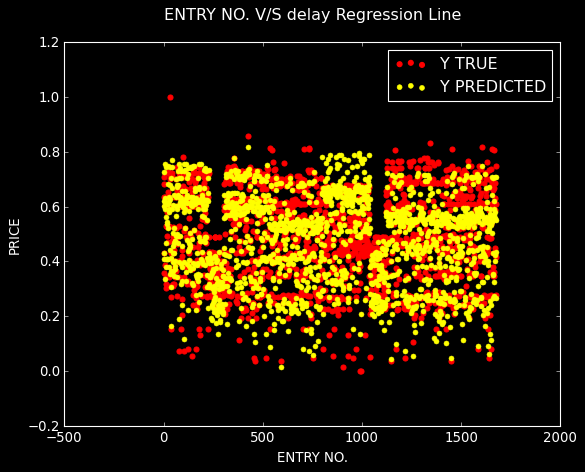

In [89]:
y_test_pred = lasso_reg.predict(x_test_fs)
y_test_pred = y_test_pred.reshape(y_test_pred.shape[0],1)
predicted_price['lasso_regression_price'] = np.exp(y_s.inverse_transform(y_test_pred).reshape(lasso_reg.predict(x_test_fs).shape[0])).round()
reg_metrics['LASSO REGRESSION'] = [mean_abs_error,scr,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance]    
plot_regression_line(x_eval_fs.index,y_eval,y_pred)

 ### 3. RANDOM FOREST REGRESSOR

In [90]:
gc.collect()

5820

In [91]:
%%time

# Performing Grid-Search
#gsc = GridSearchCV(estimator = RandomForestRegressor(),param_grid={'max_depth':[9,10],'n_estimators':(500,1000)},cv=5,scoring = 'neg_mean_squared_error',verbose=1,n_jobs=-1)
#grid_result = gsc.fit(x_train,y_train)
#best_params = grid_result.best_params_
#print("\n\nBest Params : \n",best_params)

rfr = RandomForestRegressor(max_depth=13,n_estimators=100,random_state=False,verbose=True) 

rfr.fit(x_train_fs,y_train)

y_pred = rfr.predict(x_eval_fs)

scr = rfr.score(x_eval_fs,y_eval)

mean_abs_error,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance = evaluate_metrics(x_eval_fs,y_eval,y_pred,rfr)

print("METRICS  :\n\nMean Absolute Error :  ",mean_abs_error,"\nScore :   ",scr,"\nMean Squared Error :  ",mean_sq_error,"\nRoot Mean Squared Error :  ",root_mean_sq_error,"\nR2 Square :  ",r2_scr,"\nMedian Absolute Score :  ",median_abs_score,"\nExplained Variance Score :  ",explained_variance)    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


METRICS  :

Mean Absolute Error :   0.04738715634274665 
Score :    0.8312160414004535 
Mean Squared Error :   0.004862325403767865 
Root Mean Squared Error :   0.06973037647803047 
R2 Square :   0.8312160414004535 
Median Absolute Score :   0.031004899371648187 
Explained Variance Score :   0.8390829097217977
CPU times: user 9.44 s, sys: 8.47 ms, total: 9.45 s
Wall time: 9.45 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


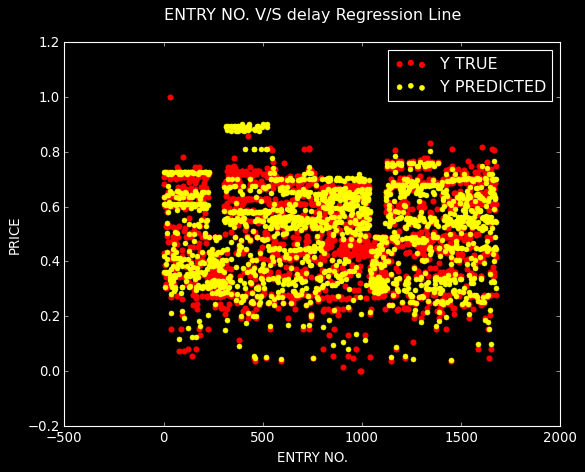

In [92]:
predicted_price['random_forest_price'] = np.exp(y_s.inverse_transform(rfr.predict(x_test_fs).reshape(rfr.predict(x_test_fs).shape[0],1))).reshape(ridge_mod.predict(x_test_fs).shape[0]).round()
reg_metrics['RANDOM FOREST'] = [mean_abs_error,scr,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance]    
plot_regression_line(x_eval_fs.index,y_eval,y_pred)

### 4. DECISION TREE REGRESSOR

In [93]:
dtr = DecisionTreeRegressor(max_depth = 8,random_state= 2)
dtr.fit(x_train,y_train)
y_pred1 = dtr.predict(x_eval)
mean_abs_error,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance = evaluate_metrics(x_eval,y_eval,y_pred,dtr)
scr = dtr.score(x_eval,y_eval)
print("METRICS  :\n\nMean Absolute Error :  ",mean_abs_error,"\nScore :   ",scr,"\nMean Squared Error :  ",mean_sq_error,"\nRoot Mean Squared Error :  ",root_mean_sq_error,"\nR2 Square :  ",r2_scr,"\nMedian Absolute Score :  ",median_abs_score,"\nExplained Variance Score :  ",explained_variance)   

METRICS  :

Mean Absolute Error :   0.04738715634274665 
Score :    0.783891508779839 
Mean Squared Error :   0.004862325403767865 
Root Mean Squared Error :   0.06973037647803047 
R2 Square :   0.8312160414004535 
Median Absolute Score :   0.031004899371648187 
Explained Variance Score :   0.8390829097217977


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


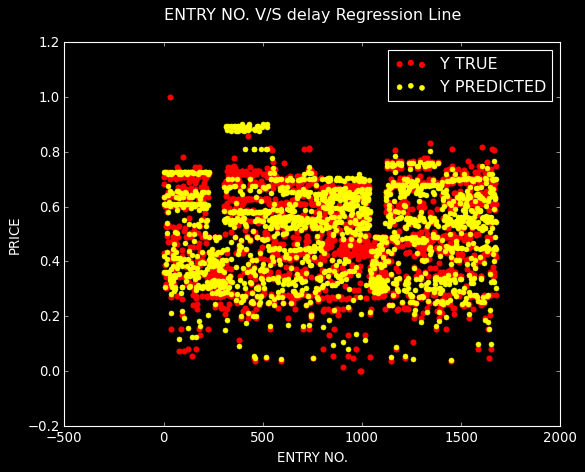

In [94]:
reg_metrics['DECISION TREE'] = [mean_abs_error,scr,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance]
predicted_price['decision_tree_price'] = np.exp(y_s.inverse_transform(dtr.predict(x_test_fs).reshape(rfr.predict(x_test_fs).shape[0],1))).reshape(ridge_mod.predict(x_test_fs).shape[0]).round()
plot_regression_line(x_eval.index,y_eval,y_pred)

### 5. XGB REGRESSOR

In [95]:
xgb_model = xgb.XGBRegressor(max_depth = 12,eta = 0.3,n_estimators = 100,objective = 'reg:squarederror',gamma = 0.01)
xgb_model.fit(x_train,y_train)
y_pred = xgb_model.predict(x_eval)
mean_abs_error,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance = evaluate_metrics(x_eval,y_eval,y_pred,dtr)
scr = xgb_model.score(x_eval,y_eval)
print("METRICS  :\n\nMean Absolute Error :  ",mean_abs_error,"\nScore :   ",scr,"\nMean Squared Error :  ",mean_sq_error,"\nRoot Mean Squared Error :  ",root_mean_sq_error,"\nR2 Square :  ",r2_scr,"\nMedian Absolute Score :  ",median_abs_score,"\nExplained Variance Score :  ",explained_variance)   

METRICS  :

Mean Absolute Error :   0.048741902746080486 
Score :    0.802228792123291 
Mean Squared Error :   0.005697389587089354 
Root Mean Squared Error :   0.07548105449110627 
R2 Square :   0.802228792123291 
Median Absolute Score :   0.028104661331367353 
Explained Variance Score :   0.8195210948986186


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


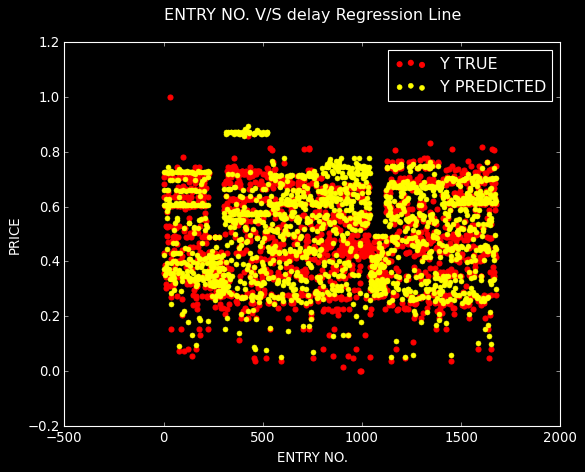

In [96]:
x_test = x_test[x_train.columns]
reg_metrics['XGB_REGRESSION'] = [mean_abs_error,scr,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance]
predicted_price['xgb_regression_price'] = np.exp(y_s.inverse_transform(xgb_model.predict(x_test).reshape(rfr.predict(x_test_fs).shape[0],1))).reshape(ridge_mod.predict(x_test_fs).shape[0]).round()
plot_regression_line(x_eval.index,y_eval,y_pred)

### COMPUTED METRICS

In [97]:
metric_names = ["MEAN ABSOLUTE ERROR","MODEL SCORE","MEAN SQUARED ERROR","ROOT MEAN SQUARED ERROR","R2 SCORE","MEDIAN ABSOLUTE ERROR","EXPLAINED VARIANCE SCORE"]

In [98]:
for col in reg_metrics.keys():
    reg_metrics[col] = np.around(reg_metrics[col],4).astype('str')

In [99]:
computed_metrics = pd.DataFrame(reg_metrics,index = metric_names).T
computed_metrics.T

,RIDGE REGRESSION,LASSO REGRESSION,RANDOM FOREST,DECISION TREE,XGB_REGRESSION
MEAN ABSOLUTE ERROR,0.0746,0.0696,0.0474,0.0474,0.0487
MODEL SCORE,0.7006,0.7249,0.8312,0.7839,0.8022
MEAN SQUARED ERROR,0.0086,0.0079,0.0049,0.0049,0.0057
ROOT MEAN SQUARED ERROR,0.0929,0.089,0.0697,0.0697,0.0755
R2 SCORE,0.7006,0.7249,0.8312,0.8312,0.8022
MEDIAN ABSOLUTE ERROR,0.0625,0.058,0.031,0.031,0.0281
EXPLAINED VARIANCE SCORE,0.7291,0.7325,0.8391,0.8391,0.8195


 ### COMPUTATION OF OUR ESTIMATED PAYMENT DATE 

In [100]:
test_data_1.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Dep_Time',
       'Arrival_Time', 'Duration', 'Total_Stops', 'Additional_Info'],
      dtype='object')

In [101]:
test_data_1.columns = ['AIRLINE','DATE OF JOURNEY','SOURCE','DESTINATION','DEPARTURE TIME','ARRIVAL TIME','DURATION','TOTAL STOPS','ADDITIONAL INFO']

output = test_data_1

output['PREDICTED PRICE(RIDGE REGRESION)'] = predicted_price['ridge_regression_price']
output['PREDICTED PRICE(LASSO REGRESION)'] = predicted_price['lasso_regression_price']
output['PREDICTED PRICE(RANDOM FOREST REGRESION)'] = predicted_price['random_forest_price']
output['PREDICTED PRICE(DECISION TREE REGRESION)'] = predicted_price[ 'decision_tree_price']
output['PREDICTED PRICE(XGBOOST REGRESION)'] = predicted_price['xgb_regression_price']

In [102]:
output

,AIRLINE,DATE OF JOURNEY,SOURCE,DESTINATION,DEPARTURE TIME,ARRIVAL TIME,DURATION,TOTAL STOPS,ADDITIONAL INFO,PREDICTED PRICE(RIDGE REGRESION),PREDICTED PRICE(LASSO REGRESION),PREDICTED PRICE(RANDOM FOREST REGRESION),PREDICTED PRICE(DECISION TREE REGRESION),PREDICTED PRICE(XGBOOST REGRESION)
0,SpiceJet,12-05-2019,Kolkata,Banglore,15:05,20:20,5h 15m,1 stop,No info,4386.0,6187.0,15357.0,16102.0,5657.0
1,Air India,15-03-2019,Delhi,Cochin,18:05,21:10,3h 5m,non-stop,No info,10687.0,8234.0,9083.0,8957.0,5975.0
2,Jet Airways,24-06-2019,Delhi,Cochin,11:45,25-06-2021 04:25,16h 40m,2 stops,No info,9237.0,7506.0,14519.0,16102.0,21535.0
3,SpiceJet,21-06-2019,Kolkata,Banglore,09:00,11:25,2h 25m,non-stop,No info,3715.0,6330.0,14559.0,16102.0,3913.0
4,IndiGo,27-04-2019,Kolkata,Banglore,14:25,16:55,2h 30m,non-stop,No info,5157.0,5696.0,15141.0,16102.0,4713.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2129,Air India,06-04-2019,Banglore,Delhi,17:00,19:45,2h 45m,non-stop,No info,3612.0,7187.0,15423.0,16102.0,5793.0
2130,Jet Airways,01-04-2019,Kolkata,Banglore,06:30,20:45,14h 15m,1 stop,No info,4399.0,6921.0,15433.0,16102.0,12763.0
2131,Multiple carriers,15-05-2019,Delhi,Cochin,08:45,19:00,10h 15m,1 stop,No info,5429.0,7844.0,9083.0,8957.0,10349.0
2132,Air India,03-03-2019,Delhi,Cochin,21:30,04-03-2021 19:15,21h 45m,2 stops,No info,6732.0,7177.0,15506.0,16102.0,13720.0


In [103]:
output['PREDICTED PRICE(RANDOM FOREST REGRESION)'].to_csv('PREDICTED PRICE(RANDOM FOREST REGRESION).csv')
output['PREDICTED PRICE(XGBOOST REGRESION)'].to_csv('PREDICTED PRICE(XGBOOST REGRESION).csv')
output['PREDICTED PRICE(DECISION TREE REGRESION)'].to_csv('PREDICTED PRICE(DECISION TREE REGRESION).csv')

### FINAL ROOT MEAN SQUARE VALUES

In [104]:
computed_metrics["ROOT MEAN SQUARED ERROR"].to_frame().T

,RIDGE REGRESSION,LASSO REGRESSION,RANDOM FOREST,DECISION TREE,XGB_REGRESSION
ROOT MEAN SQUARED ERROR,0.0929,0.089,0.0697,0.0697,0.0755
